# Libraries

In [1]:
import math
from loguru import logger as lg
import numpy as np
import pandas as pd
from time import perf_counter
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import collections
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram as Dendrogram, _plot_dendrogram, leaves_list, linkage as Linkage

In [2]:
import sklearn.datasets as data
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan._hdbscan_tree import compute_stability

In [3]:
from manim import *
from manim_slides import Slide

Manim Community v0.13.1

# Welcome Screen 

# Slide 1 - DBSCAN

In [4]:
params = "-v WARNING    -ql --disable_caching --progress_bar leave Slide1"
paramsc = "-v WARNING    -ql --progress_bar leave Slide1"
paramsk = "-v WARNING    -qk --disable_caching --progress_bar leave Slide1"

In [93]:
data_points = np.load(r"data\clusterable_data.npy")

In [6]:
def plot_clusters(data_points, algorithm, args, kwds, make_cluster):
    
    # Getting Lables
    if make_cluster:
        labels = algorithm(*args, **kwds).fit_predict(data_points)

    # Settings
    sns.set_context('poster')
    sns.set_style('white')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.5, 's' : 10, 'linewidths':0}
    
    # Set Colors
    if make_cluster:
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    else:
        colors = [(0.0, 0.0, 0.0) for _ in range(len(data_points))]

    # Ploting
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    ax.scatter(data_points.T[0], data_points.T[1], c=colors, **plot_kwds)

    # Print Eps value
    if make_cluster:
        plt.text(-0.5, 0.8, f'Eps: {kwds["eps"]:.3f}', fontsize=14)

    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

    # Draw fig
    fig.canvas.draw()

    # Create buffer
    buf = fig.canvas.buffer_rgba()

    # Create Image Mobject
    img = ImageMobject(buf).scale(1)
    plt.close(fig)
    
    return img, fig

In [ ]:
%%manim $paramsc
plt.rcParams['figure.dpi'] = 300

class Slide1(Slide):
    def construct(self):
        
        title = Text("DBSCAN", color=WHITE).scale(1.5)
        title.to_edge(UP)
        self.play(Write(title))
        self.pause()

        subtitle = Text("Density-Based Spatial Clustering of Applications with Noise", font="Montserrat", color=WHITE).scale(0.5).next_to(title, DOWN)
        self.add(subtitle)
        self.wait()

        info = Text("by Martin Ester, Hans-Peter Kriegel, Jörg Sander, Xiaowei Xu, 1996", font="Montserrat", color=WHITE).scale(0.5).next_to(title, DOWN).shift(DOWN*0.5)
        self.add(info)
        self.wait()
        self.pause()

        self.play(FadeOut(subtitle), FadeOut(info))

        # PLot points
        img, _ = plot_clusters(data_points, DBSCAN, (), {'eps': 0.022}, False)
        img.scale(0.5).to_edge(DOWN)
        self.play(FadeIn(img))
        self.pause()

        # Plot points with clusters
        img2, _ = plot_clusters(data_points, DBSCAN, (), {'eps': 0.022}, True)
        img2.scale(0.5).to_edge(DOWN)
        self.play(ReplacementTransform(img, img2, run_time=2))
        self.pause()

        # Problem with DBSCAN
        title2 = Text("Problem with DBSCAN", color=WHITE)
        title2.scale(1.5).to_edge(UP)
        self.play(TransformMatchingShapes(title, title2))

        # Plot points with clusters
        img3, _ = plot_clusters(data_points, DBSCAN, (), {'eps': 0.001}, True)
        img3.scale(0.5).to_edge(DOWN)
        self.play(ReplacementTransform(img2, img3))
        self.pause()

        eps_min = 0.001
        eps = 0.001
        eps_max = 0.03

        tr_eps = ValueTracker(eps)
        image, _ = plot_clusters(data_points, DBSCAN, (), {'eps':eps}, True)
        image.scale(0.5).to_edge(DOWN)

        self.play(ReplacementTransform(img3, image))

        def update_image(mob):
            new_mob, _ = plot_clusters(data_points, DBSCAN, (), {'eps':tr_eps.get_value()}, True)
            new_mob.scale(0.5).to_edge(DOWN)
            mob.become(new_mob)

        image.add_updater(update_image)

        self.start_loop()
        self.play(tr_eps.animate.set_value(eps_max), run_time=10, rate_func=rate_functions.linear)
        self.play(tr_eps.animate.set_value(eps_min), run_time=10, rate_func=rate_functions.double_smooth)
        self.end_loop()

        self.wait()
        self.pause()

        # Fade out
        self.play(FadeOut(title2))
        self.play(FadeOut(image, scale=0.5))
        self.wait()


# Slide 2 - HDBSCAN

In [ ]:
params = "-v WARNING    -ql --disable_caching --progress_bar leave Slide2"
paramsc = "-v WARNING    -ql --progress_bar leave Slide2"
paramsk = "-v WARNING    -qk --disable_caching --progress_bar leave Slide2"

In [ ]:
class Slide2(Slide):
    def construct(self):

        # Title
        title = Text("HDBSCAN", color=WHITE).scale(1.5)
        self.wait()
        self.play(Write(title))
        self.wait()
        self.pause()

        # Move up and write full name
        self.play(title.animate.to_edge(UP))
        title2 = Text("Hierarchical Density-Based Spatial Clustering of Applications with Noise", font="Montserrat", color=WHITE).scale(0.5).next_to(title, DOWN)
        self.play(FadeIn(title2))
        self.wait()
        self.pause()

        # Color the word Hierarchical and Density
        self.play(Indicate(title2[0:12]))
        # TODO: Add an image of dendogram here
        self.wait()

        self.play(Indicate(title2[12:20]))
        self.wait()
        # TODO: Add an Density colored image here
        self.pause()

        # Fade out all
        self.play(FadeOut(title2))

In [ ]:
%%manim $paramsc
plt.rcParams['figure.dpi'] = 300


# Slide 3 - Steps

In [7]:
def plot_clusters(data_points, algorithm, args, kwds, make_cluster):
    
    # Getting Lables
    if make_cluster:
        labels = algorithm(*args, **kwds).fit_predict(data_points)

    # Settings
    sns.set_context('poster')
    sns.set_style('white')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.5, 's' : 10, 'linewidths':0}
    
    # Set Colors
    if make_cluster:
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    else:
        colors = [(0.0, 0.0, 0.0) for _ in range(len(data_points))]

    # Ploting
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    ax.scatter(data_points.T[0], data_points.T[1], c=colors, **plot_kwds)

    # Print Eps value
    if make_cluster:
        plt.text(-0.5, 0.8, f'Eps: {kwds["eps"]:.3f}', fontsize=14)

    # Remove ticks
    # plt.xticks([])
    # plt.yticks([])
    # frame = plt.gca()
    # frame.axes.get_xaxis().set_visible(False)
    # frame.axes.get_yaxis().set_visible(False)

    # Draw fig
    fig.canvas.draw()

    # Create buffer
    buf = fig.canvas.buffer_rgba()

    # Create Image Mobject
    img = ImageMobject(buf).scale(1)
    plt.close(fig)
    
    return img, fig

In [8]:
test_data = data.make_blobs(n_samples=50, centers=2, cluster_std=0.1, n_features=2, random_state=42, center_box=(0, 1))[0]
# Plot
_, fig = plot_clusters(test_data, DBSCAN, (), {'min_cluster_size': 5}, False)

In [9]:
name = "Slide3"
params = f"-v WARNING -ql --disable_caching --progress_bar leave {name}"
paramsc = f"-v WARNING -ql --progress_bar leave {name}"
paramsk = f"-v WARNING -qk --disable_caching --progress_bar leave {name}"

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', gen_min_span_tree=True)
clusterer.fit(test_data)
min_spanning_tree   = clusterer.minimum_spanning_tree_
single_linkage_tree = clusterer.single_linkage_tree_
condensed_tree      = clusterer.condensed_tree_

class Slide3(ZoomedScene, Slide):
    def construct(self):

        dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')

        # Title
        title = Title("HDBSCAN", color=WHITE, match_underline_width_to_text=True).scale(1.5).to_edge(UP)

        # Creating Title and Algorithm
        def create_title_and_algorithm():

            # Print the Algorithm
            algorithm = Text("Algorithm", color=RED).scale(.6).next_to(title, DOWN*3)
            l1 = Line(LEFT*3, RIGHT*4, color=RED)
            l2 = Line(LEFT*3, RIGHT*4, color=RED)
            title_grp = VGroup(l1, algorithm, l2).arrange(DOWN, buff=0.1)
            algorithm.shift(LEFT)
            l1.shift(LEFT)
            l2.shift(LEFT)

            # Steps
            step1 = Tex(r'$1.$ Compute the core distance.', color=BLUE_D).scale(0.55).next_to(title_grp, DOWN)
            step2 = Tex(r'$2.$ Compute an Mutual Reachability Distance (MRD).', color=BLUE_D).scale(0.55)
            step3 = Tex(r'$3.$ Build a Minimum Spanning Tree, using MRD', color=BLUE_D).scale(0.55)
            step4 = Tex(r'$4.$ Construct Cluster Hierarchy using Single Linkage', color=BLUE_D).scale(0.55)
            step5 = Tex(r'$5.$ Condense the clusters using $k$', color=BLUE_D).scale(0.55)
            step6 = Tex(r'$6.$ Extract clusters', color=BLUE_D).scale(0.55)

            steps = VGroup(step1, step2, step3, step4, step5, step6).arrange(DOWN, center=False, aligned_edge=LEFT, buff=0.3)

            algorithm_group = VGroup(title_grp, steps).shift(UP)
            steps.shift(LEFT*1.5)
            algorithm_group.shift(RIGHT)
            
            self.play(Write(title_grp))
            self.wait()
            self.play(AnimationGroup(
                *[FadeIn(step, shift=UP) for step in steps],
                lag_ratio=1
            ))
            self.wait()

            return title, title_grp, steps ,algorithm_group
        
        # Input Dots
        def input_dots(test_data):

            dots = VGroup()
            p_scale = 8
            for  idx, (x, y) in enumerate(test_data):
                dot = Dot(point=[x*p_scale, y*p_scale, 0], color=WHITE).scale(0.5)
                dots.add(dot)

            dots.move_to(ORIGIN)
            background = ScreenRectangle(aspect_ratio=1)
            background.set(height=6.5)
            background.set_fill(BLACK, 1)
            background.set_stroke(width=0)
            background.move_to(ORIGIN)
            dots.add_to_back(background)
            dots.shift(RIGHT*3.5)

            self.add(dots.submobjects[0])
            self.play(AnimationGroup(
                *[GrowFromCenter(dot) for dot in dots.submobjects[1:]],
                lag_ratio=0.05,
                rate_func=rate_functions.ease_in_cubic
            ))
            
            return dots

        # Focus on step
        def focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(YELLOW).scale(1.2).shift(RIGHT*.3)
        
        # Remove focus on step
        def remove_focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(BLUE_D).scale(1/1.2).shift(LEFT*.3)

        # Perform Step 1
        def perform_step_1(steps, dots):

            self.play(focus_on_step(steps, 0))

            zoomed_camera = self.zoomed_camera
            frame = zoomed_camera.frame
            frame.set_color(PURPLE)

            zoomed_display = self.zoomed_display
            zoomed_display_frame = zoomed_display.display_frame
            zoomed_display_frame.set_color(RED)

            zd_rect = BackgroundRectangle(zoomed_display, fill_opacity=0, buff=MED_SMALL_BUFF)
            self.add_foreground_mobject(zd_rect)

            unfold_camera = UpdateFromFunc(zd_rect, lambda rect: rect.replace(zoomed_display))
            
            # scale_factor = [0.5, 2, 0]
            # frame.scale(scale_factor).scale(0.5)
            # zoomed_display.scale(scale_factor).to_corner(DR)
            zoomed_display.to_edge(DOWN).shift(LEFT*3)

            dot_idx = 28
            frame.move_to(dots[dot_idx].get_center())
            self.play(Create(frame))
            self.activate_zooming()
            self.play(self.get_zoomed_display_pop_out_animation(), unfold_camera)
            self.wait(0.5)

            self.play(dots[dot_idx].animate.set_color(RED))
            self.wait()


            # Calculate the distance matrix
            dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')
            k = 5
            radii = []
            core_circles = []
            sorted_dots = []
            
            # Function to calculate the k nearest neighbors distance
            def show_core_distance(dist_matrix, dot_idx, k):
            
                dists = dist_matrix[dot_idx-1]
                pts = []
                while len(pts) <= k+1:
                    pt_idx = np.argmin(dists)
                    pts.append(dots[pt_idx+1])
                    dists[pt_idx] = np.inf
                
                old_radius = euclidean(dots[dot_idx].get_center(), pts[1].get_center())
                self.play(dots[dot_idx].animate.set_color(RED))
                core_dist_circle = Circle(radius=old_radius, color=BLUE, fill_opacity=0.2, stroke_width=0.5).move_to(dots[dot_idx].get_center())

                frame_h = frame.height
                if 2*old_radius > frame_h:
                    frame_s = (2 * old_radius) / (frame_h)
                    self.play(frame.animate.scale(frame_s), Create(core_dist_circle))
                else:
                    self.play(Create(core_dist_circle))
                self.wait()
                
                for pt in pts[2:]:
                    pt = pt.get_center()
                    new_radius = euclidean(dots[dot_idx].get_center(), pt)
                    s = new_radius / old_radius

                    frame_h = frame.height
                    if 2*new_radius > frame_h:
                        frame_s = (2 * new_radius) / (frame_h)
                        self.play(frame.animate.scale(frame_s), core_dist_circle.animate.scale(s))
                    else:
                        self.play(core_dist_circle.animate.scale(s))

                    old_radius = new_radius
                    self.wait(0.1)
                
                self.wait()
                self.play(dots[dot_idx].animate.set_color(WHITE))
                self.wait()
                radii.append(old_radius)
                core_circles.append(core_dist_circle)
                sorted_dots.append(dots[dot_idx])

            show_core_distance(dist_matrix, dot_idx, k)

            dot_idx = 43
            self.play(frame.animate.move_to(dots[dot_idx].get_center()))
            frame_h = frame.height
            self.wait(0.5)

            show_core_distance(dist_matrix, dot_idx, k)
            self.play(self.get_zoomed_display_pop_out_animation(), unfold_camera, rate_func=lambda t: smooth(1 - t))
            self.play(Uncreate(zoomed_display_frame), FadeOut(frame))
            self.wait()

            def get_core_circle(dist_matrix, dot_idx, k):
                dists = dist_matrix[dot_idx-1]
                pts = []
                while len(pts) <= k+1:
                    pt_idx = np.argmin(dists)
                    pts.append(dots[pt_idx+1])
                    dists[pt_idx] = np.inf
                
                pt = pts[-1]

                radius = euclidean(dots[dot_idx].get_center(), pt.get_center())
                radii.append(radius)
                core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2, stroke_width=0.5).move_to(dots[dot_idx].get_center())
                core_circles.append(core_circle)
                sorted_dots.append(dots[dot_idx])
                return core_circle

            circles = []
            for dot_idx in range(1, len(dots)):
                
                if dot_idx == 28 or dot_idx == 43:
                    continue
                circles.append(get_core_circle(dist_matrix, dot_idx, k))
            
            c = interpolate_color(YELLOW, RED, min(1, ((radii[0] - np.min(radii)) / np.mean(radii)) * 0.75))
            self.play(core_circles[0].animate.set_color(c))
            self.wait(0.5)

            c = interpolate_color(YELLOW, RED, min(1, ((radii[1] - np.min(radii)) / np.mean(radii)) * 0.75))
            self.play(core_circles[1].animate.set_color(c))

            for idx in range(len(circles)):
                c = interpolate_color(YELLOW, RED, min(1, ((radii[idx] - np.min(radii)) / np.mean(radii)) * 0.75))
                circles[idx].set_color(c)

            self.play(
                AnimationGroup(
                    *[Create(circle) for circle in circles],
                    lag_ratio=0.1,
                    rate_func=rate_functions.ease_in_out_quart
                )
            )
            self.wait()

            self.play(
                AnimationGroup(
                    *[sorted_dots[idx].animate.set_color(core_circles[idx].color) for idx in range(len(sorted_dots))],
                    *[FadeOut(core_circles[idx], scale=0.5) for idx in range(len(sorted_dots))],
                ) 
            )
            self.wait()

        # Perform Step 2
        def perform_step_2(steps, dots):
            self.play(remove_focus_on_step(steps, 0), focus_on_step(steps, 1))

            mrd = MathTex(
                r'\text{mrd}(',
                r'p_i',
                r',\ \ ',
                r'p_j',
                r') =  \max\Big(',
                r'\text{core}_d',  # 5
                r'(',
                r'p_i',
                r'),\ \ ',
                r'\text{core}_d',  # 9
                r'(',
                r'p_j',
                r'),\ \ ',
                r'd',  # 13
                r'(',
                r'p_i',
                r',\ \ ',
                r'p_j',
                r')\Big)'
            ).scale(0.7).next_to(steps, DOWN*3).shift(RIGHT*1.5)

            self.play(Write(mrd))
            self.wait()

            c1_color = LIGHT_BROWN
            c2_color = BLUE_D
            l_color  = GREEN_D

            def present_mrd(dots, mrd, idx1, idx2):

                # Choose Points
                dot1 = dots[idx1]
                dot2 = dots[idx2]
                old_color1 = dot1.get_color()
                old_color2 = dot2.get_color()
                self.play(dot1.animate.set_color(c1_color), Flash(dot1), mrd.animate.set_color_by_tex('p_i', c1_color))
                self.wait()

                self.play(dot2.animate.set_color(c2_color), Flash(dot2), mrd.animate.set_color_by_tex('p_j', c2_color))
                self.wait()

                # Show Core
                k = 5

                def get_core_circle(dist_matrix, dot_idx, k):
                    dists = dist_matrix[dot_idx-1]
                    pts = []
                    while len(pts) <= k+1:
                        pt_idx = np.argmin(dists)
                        pts.append(dots[pt_idx+1])
                        dists[pt_idx] = np.inf
                    
                    pt = pts[-1]

                    radius = euclidean(dots[dot_idx].get_center(), pt.get_center())
                    core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2).move_to(dots[dot_idx].get_center())

                    return core_circle

                core_circle1 = get_core_circle(dist_matrix, idx1, k).set_color(c1_color)
                core_circle2 = get_core_circle(dist_matrix, idx2, k).set_color(c2_color)

                self.play(Create(core_circle1), Indicate(mrd[5], color=c1_color, scale_factor=2))
                self.wait()
                self.play(Create(core_circle2), Indicate(mrd[9], color=c2_color, scale_factor=2))
                self.wait()

                # Draw line from dot1 to dot2
                line = Line(dot1.get_center(), dot2.get_center(), color=l_color)
                self.play(Create(line), Indicate(mrd[13], color=l_color, scale_factor=2))
                self.wait()

                len_dict = {
                    core_circle1: core_circle1.width,
                    core_circle2: core_circle2.width,
                    line: line.get_length()
                }
                # sort according to length
                inds = [k for k, _ in sorted(len_dict.items(), key=lambda item: item[1], reverse=True)]

                # Show the distance
                self.play(Indicate(inds[0], color=inds[0].color, scale_factor=2), FadeOut(inds[1]), FadeOut(inds[2]))
                self.wait()

                self.play(FadeOut(inds[0]), dot1.animate.set_color(old_color1), dot2.animate.set_color(old_color2))
                self.wait()

            # d as mrd
            present_mrd(dots, mrd, 28, 37)
            self.pause()

            # core_dist as mrd
            present_mrd(dots, mrd, 43, 13)
            self.pause()

            def show_d_mrd_rel(dots, mrd):

                test_dots = VGroup()
                dot1 = dots[40]
                dot2 = dots[36]
                test_dots.add(dot1.copy())
                test_dots.add(dot2.copy())
                test_dots.shift(LEFT*2.5 + DOWN*0.5)
                self.play(TransformFromCopy(dot1, test_dots[0]), TransformFromCopy(dot2, test_dots[1]))
                self.wait()

                # Difference between eculidean metric and mrd
                zoomed_camera = self.zoomed_camera
                frame = zoomed_camera.frame
                frame.set_color(PURPLE)

                zoomed_display = self.zoomed_display
                zoomed_display_frame = zoomed_display.display_frame
                zoomed_display_frame.set_color(RED)

                zd_rect = BackgroundRectangle(zoomed_display, fill_opacity=0, buff=MED_SMALL_BUFF)
                self.add_foreground_mobject(zd_rect)

                unfold_camera = UpdateFromFunc(zd_rect, lambda rect: rect.replace(zoomed_display))
                zoomed_display.to_edge(DR)

                frame.move_to(test_dots.get_center())
                frame.width=test_dots.width*1.5
                frame.height=test_dots.height*1.5
                self.play(Create(frame))
                self.activate_zooming()
                self.play(self.get_zoomed_display_pop_out_animation(), unfold_camera)
                self.wait(0.5)

                old_color1 = dot1.get_color()
                old_color2 = dot2.get_color()
                self.play(dot1.animate.set_color(c1_color), Flash(dot1), mrd.animate.set_color_by_tex('p_i', c1_color), test_dots[0].animate.set_color(c1_color))

                self.play(dot2.animate.set_color(c2_color), Flash(dot2), mrd.animate.set_color_by_tex('p_j', c2_color), test_dots[1].animate.set_color(c2_color))
                self.wait()

                line = Line(test_dots[0].get_center(), test_dots[1].get_center(), color=l_color, stroke_width=0.8)
                line_core = Line(dot1.get_center(), dot2.get_center(), color=l_color)
                self.play(Create(line_core), Create(line), Indicate(mrd[13], color=l_color, scale_factor=2))

                def get_core_circle(dist_matrix, dot_idx, k):
                    dists = dist_matrix[dot_idx-1]
                    pts = []
                    while len(pts) <= k+1:
                        pt_idx = np.argmin(dists)
                        pts.append(dots[pt_idx+1])
                        dists[pt_idx] = np.inf
                    
                    pt = pts[-1]

                    radius = euclidean(dots[dot_idx].get_center(), pt.get_center())
                    core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2).move_to(dots[dot_idx].get_center())

                    return core_circle
                k = 5
                core_circle1 = get_core_circle(dist_matrix, 40, k).set_color(c1_color)
                core_circle2 = get_core_circle(dist_matrix, 36, k).set_color(c2_color)

                self.play(Create(core_circle1), Indicate(mrd[5], color=c1_color, scale_factor=2))
                self.play(Create(core_circle2), Indicate(mrd[9], color=c2_color, scale_factor=2))
                self.wait()

                len_dict = {
                    core_circle1: core_circle1.width,
                    core_circle2: core_circle2.width,
                    line_core: line_core.get_length()
                }

                # sort according to length
                inds = [k for k, _ in sorted(len_dict.items(), key=lambda item: item[1], reverse=True)]

                test_dots[0].add_updater(lambda d: d.move_to(line.get_start()))
                test_dots[1].add_updater(lambda d: d.move_to(line.get_end()))
                frame.add_updater(lambda f: f.set(width=test_dots.width*1.5))
                frame.add_updater(lambda f: f.set(height=test_dots.height*1.5))
                frame.add_updater(lambda f: f.set(center=test_dots.get_center()))
                self.wait()

                # Show the distance
                self.play(FadeOut(inds[1]), FadeOut(inds[2]))
                self.wait()
                self.play(line.animate.set_length(inds[0].width))
                self.wait()

                self.play(FadeOut(inds[0]), dot1.animate.set_color(old_color1), dot2.animate.set_color(old_color2))
                self.wait()

                self.play(self.get_zoomed_display_pop_out_animation(), unfold_camera, rate_func=lambda t: smooth(1 - t))
                self.play(Uncreate(zoomed_display_frame), FadeOut(frame), FadeOut(test_dots), FadeOut(zd_rect), FadeOut(line))
                self.wait()

            show_d_mrd_rel(dots, mrd)
            # Indicate mrd for all points
            rect = SurroundingRectangle(mrd, color=BLACK, buff=0.1)
            self.play(AnimationGroup(
                *[Flash(dot) for dot in dots],
                lag_ratio=0.05
            ), ShowPassingFlash(rect.set_color(GREEN_D), run_time=3, time_width=2))
            self.wait(2)

            self.play(FadeOut(mrd))
            self.wait()

        # Perform Step 3
        def perform_step_3(steps, dots):
            self.play(remove_focus_on_step(steps, 1), focus_on_step(steps, 2))
            self.wait()

            min_spanning_array = min_spanning_tree.to_numpy()[:,:2]
            dist_array = min_spanning_tree.to_numpy()[:,2]

            def draw_tree(dots, min_spanning_array, dist_array):

                # Create minimum spanning tree
                global mst
                mst = []
                max_len  = max(dist_array)
                mean_len = np.mean(dist_array)
                min_len  = min(dist_array)
                for idx, pt in enumerate(min_spanning_array):
                    c = interpolate_color(YELLOW, RED, min(dist_array[idx]/max_len, 1))
                    line = Line(dots[int(pt[0])+1].get_center(), dots[int(pt[1])+1].get_center(), color=c)
                    mst.append(line)
                
                self.play(AnimationGroup(*[Create(line) for line in mst], lag_ratio=0.1))

            draw_tree(dots, min_spanning_array, dist_array)

        single_linkage_tree = clusterer.single_linkage_tree_
        linkage     = single_linkage_tree.to_numpy()
        dend_dict   = Dendrogram(single_linkage_tree.to_numpy(), get_leaves=True, no_plot=True)
        icoord      = dend_dict['icoord']
        dcoord      = dend_dict['dcoord']
        ivl         = dend_dict['ivl']
        heights     = linkage[:,2]
        max_height  = max(heights)
        min_height  = min(heights)

        
        def perform_step_4(steps, dots):
            linkage = single_linkage_tree.to_numpy()
            dend_dict = Dendrogram(single_linkage_tree.to_numpy(), get_leaves=True, no_plot=True)
            icoord = dend_dict['icoord']
            dcoord = dend_dict['dcoord']
            ivl    = dend_dict['ivl']
            heights = linkage[:,2]
            max_height = max(heights)
            min_height = min(heights)

            self.play(remove_focus_on_step(steps, 2), focus_on_step(steps, 3))
            self.wait(2)
            lines       = []
            global dendrogram
            dendrogram  = VGroup()
            m           = 10
            n           = 60

            label_position_x = set()
            label_position_y = set()
            dendrogram_dots  = []

            for idx in range(len(ivl)-1):

                x1, x2, x3, x4 = icoord[idx]
                y1, y2, y3, y4 = dcoord[idx]
                lable          = ivl[idx]

                x1, x2, x3, x4 = x1/n, x2/n, x3/n, x4/n
                y1, y2, y3, y4 = y1*m, y2*m, y3*m, y4*m

                c = WHITE

                line1 = Line([x1, y1, 0], [x2, y2, 0], color=c, stroke_width=0.75)
                line2 = Line([x2, y2, 0], [x3, y3, 0], color=c, stroke_width=0.75)
                line3 = Line([x3, y3, 0], [x4, y4, 0], color=c, stroke_width=0.75)
                l1_idx = len(lines) - 3
                l2_idx = len(lines) - 2
                l3_idx = len(lines) - 1
                lines.extend([line1, line2, line3])

                if y1 == 0:
                    label_position_x.add(x1)
                    label_position_y.add(y1)
                    dendrogram_dots.append(Dot(point=[x1, y1, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])
                dendrogram.add(line1, line2)

                if y4 == 0:
                    label_position_x.add(x4)
                    label_position_y.add(y4)
                    dendrogram_dots.append(Dot(point=[x4, y4, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])

                dendrogram.add(line3)

            dendrogram.scale(1.3).move_to(ORIGIN).shift(DOWN*2.5 + LEFT*1.5)

            dots_dict = {}
            for idx, dot in enumerate(dendrogram_dots):
                dots_dict[dot] = dot.get_center()

            sorted_dots_dict = {k: v for k, v in sorted(dots_dict.items(), key=lambda item: item[1][0])}
            sorted_dendrogram_dots = {}
            for idx, dot in enumerate(sorted_dots_dict.keys()):
                sorted_dendrogram_dots[dot] = dend_dict['leaves'][idx]

            self.play(
                AnimationGroup(*[Create(obj) if not isinstance(obj, Dot) else TransformFromCopy(dots[sorted_dendrogram_dots[obj] + 1], obj)for obj in dendrogram], lag_ratio=0.075)
            )

            self.wait(2)
       
        # Perform Step 5
        plot_data       = condensed_tree.get_plot_data()
        bar_centers     = plot_data['bar_centers']
        bar_tops        = plot_data['bar_tops']
        bar_bottoms     = plot_data['bar_bottoms']
        bar_widths      = plot_data['bar_widths']
        line_xs         = plot_data['line_xs']
        line_ys         = plot_data['line_ys']
        cluster_bounds  = plot_data['cluster_bounds']
        
        def perform_step_5(steps, dots):

            self.play(focus_on_step(steps, 4), remove_focus_on_step(steps, 3))
            global dendrogram, bars, bar_clusters
            bars = VGroup()
            bar_clusters = {}

            scale_m = 25

            max_width = max(bar_widths[:-1]) / scale_m
            min_width = min(bar_widths) / scale_m

            def get_bar(idx):
                width = bar_widths[idx] / scale_m
                height = (bar_tops[idx] - bar_bottoms[idx]) / (scale_m + 40)

                center_id = bar_centers[idx]
                center_x  = - center_id / scale_m
                center_y  = height

                return Rectangle(
                    height = height,
                    width  = width,
                    color  = interpolate_color(YELLOW_D, RED, min((width - min_width) / (max_width - min_width), 1)),
                    fill_opacity = 1,
                ), center_id, center_x, center_y
            
            for idx in range(len(bar_centers))[:-1]:

                bar, center_id, center_x, center_y = get_bar(idx)

                if center_id not in bar_clusters:
                    bar_clusters[center_id] = VGroup()
                bar_group = bar_clusters[bar_centers[idx]]

                if len(bar_group) == 0:
                    bar.move_to([center_x, center_y, 0])
                    bar_group.add(bar)

                else:
                    bar.next_to(bar_group[-1], DOWN * bar_group[-1].height/2, buff=0)
                    bar_group.add(bar)
                
                bars.add(bar)
            
            # Top bar
            bar, center_id, center_x, center_y = get_bar(-1)
            bar.move_to([center_x, (center_y - bar.height)/2, 0])
            bars.add(bar)

            bars.move_to(dendrogram.get_center()).scale(1)

            x1_pt = dendrogram.get_boundary_point(UL)[0] - 0.5
            x2_pt = dendrogram.get_boundary_point(UR)[0] + 0.5
            y_pt     = bars.get_edge_center(UP)[1]
            revel_line = Line([x1_pt, y_pt, 0], [x2_pt, y_pt, 0], stroke_width=2).move_to(bars.get_edge_center(UP))

            def condensed_graph_updater(obj):
                
                if obj.get_center()[1] < revel_line.get_center()[1]:
                    obj.set_opacity(0)
                else:
                    obj.set_opacity(1)
            
            def dendrogram_updater(obj):

                if isinstance(obj, Dot):
                    idx  = list(dendrogram).index(obj)
                    line = dendrogram[idx + 1]
                    y1   = line.get_start()[1]
                    y2   = line.get_end()[1]
                    y    = max(y1, y2)

                else:
                    y1 = obj.get_start()[1]
                    y2 = obj.get_end()[1]
                    y  = max(y1, y2)
                
                if y > revel_line.get_center()[1]:
                    obj.set_opacity(0)
                else:
                    obj.set_opacity(1)

            for obj in dendrogram:
                obj.add_updater(dendrogram_updater)

            for obj in bars:
                obj.set_opacity(0)
                obj.add_updater(condensed_graph_updater)            

            self.add(bars)

            self.wait()
            self.play(Create(revel_line))

            self.wait(2)

            self.play(revel_line.animate.move_to(np.array(bars.get_edge_center(DOWN)) + np.array([0, 0.1, 0])), run_time=5)

            self.wait()
            self.play(Uncreate(revel_line))


        # Step 6
        def perform_step_6(steps, dots):
                
            self.play(focus_on_step(steps, 5), remove_focus_on_step(steps, 4))
            self.wait(2)

            global bars, bar_clusters, mst

            rects = []
            for idx in bar_clusters:
                grp = bar_clusters[idx]

                if len(list(grp)) > 1:
                    rect = SurroundingRectangle(grp, buff=0.1)
                    self.play(Create(rect))
                    rects.append(rect)
            
            self.wait()

            self.play(AnimationGroup(
                *[Uncreate(line) for line in mst],
                FadeOut(bars),
                *[Uncreate(rect) for rect in rects]
            ))
            self.wait()

            # Get labels
            labels = clusterer.labels_
            color = [RED, YELLOW, LIGHT_GRAY]

            self.play(
                AnimationGroup(*[Flash(dots[idx1 + 1]) for idx1 in range(len(labels))], lag_ratio=0.075),
                AnimationGroup(*[dots[idx2].animate.set_color(color[labels[idx2-1]]) for idx2 in range(1, len(dots))], lag_ratio=0.075)
            )

            self.wait()
        
        
        self.add(title)
        self.wait()
        self.pause()
    
        title, title_grp, steps ,algorithm_group = create_title_and_algorithm()
        self.pause()

        # Scale Down and shift to left edge
        self.play(algorithm_group.animate.to_edge(LEFT).scale(0.8).shift(UP*1.3+LEFT), title.animate.to_corner(UL))
        self.wait()

        dots = input_dots(test_data)
        self.wait()
        self.pause()

        perform_step_1(steps, dots)
        self.pause()
        
        perform_step_2(steps, dots)
        self.pause()

        perform_step_3(steps, dots)
        self.pause()

        perform_step_4(steps, dots)
        self.pause()

        perform_step_5(steps, dots)
        self.pause()

        perform_step_6(steps, dots)
        self.pause()

        self.play(remove_focus_on_step(steps, 5))
        self.wait(2)


In [362]:
%%time
%%manim $paramsk
plt.rcParams['figure.dpi'] = 300

Animation 3: AnimationGroup(Group): 100%|##########| 360/360 [00:58<00:00,  6.11it/s]
Animation 5: _MethodAnimation(VGroup of 2 submobjects), etc.: 100%|##########| 60/60 [00:09<00:00,  6.15it/s]
Animation 7: AnimationGroup(Group): 100%|##########| 207/207 [00:20<00:00, 10.24it/s]
Animation 9: _MethodAnimation(Tex('$1.$ Compute the core distance.')): 100%|##########| 60/60 [00:10<00:00,  5.76it/s]
Animation 10: Create(ScreenRectangle): 100%|##########| 60/60 [00:04<00:00, 13.59it/s]
Animation 11: ApplyMethod(ImageMobjectFromCamera), etc.: 100%|##########| 60/60 [00:49<00:00,  1.22it/s]
Animation 20: _MethodAnimation(Circle): 100%|##########| 60/60 [00:19<00:00,  3.08it/s]
Animation 22: _MethodAnimation(ScreenRectangle), etc.: 100%|##########| 60/60 [00:19<00:00,  3.11it/s]
Animation 24: _MethodAnimation(ScreenRectangle), etc.: 100%|##########| 60/60 [00:18<00:00,  3.21it/s]
Animation 26: _MethodAnimation(ScreenRectangle), etc.: 100%|##########| 60/60 [00:20<00:00,  2.87it/s]
Animation 

CPU times: total: 16min 34s
Wall time: 42min 59s


# Testing Plots

In [ ]:
name = 'Test_Plot'
params = f"-v WARNING -ql --disable_caching --progress_bar leave {name}"
paramsc = f"-v WARNING -ql --progress_bar leave {name}"
paramsk = f"-v WARNING -qk --disable_caching --progress_bar leave {name}"
paramss = f"-v WARNING -s -qk --disable_caching --progress_bar leave {name}"

class Test_Plot(ZoomedScene):
    def construct(self):

        dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')

        title = Title("HDBSCAN", color=WHITE, match_underline_width_to_text=True).scale(1.5).to_edge(UP)
        
        # Creating Title and Algorithm
        def create_title_and_algorithm():

            # Print the Algorithm
            algorithm = Text("Algorithm", color=RED).scale(.6).next_to(title, DOWN*3)
            l1 = Line(LEFT*3, RIGHT*4, color=RED)
            l2 = Line(LEFT*3, RIGHT*4, color=RED)
            title_grp = VGroup(l1, algorithm, l2).arrange(DOWN, buff=0.1)
            algorithm.shift(LEFT)
            l1.shift(LEFT)
            l2.shift(LEFT)

            # Steps
            step1 = Tex(r'$1.$ Compute the core distance.', color=BLUE_D).scale(0.55).next_to(title_grp, DOWN)
            step2 = Tex(r'$2.$ Compute an Mutual Reachability Distance (MRD).', color=BLUE_D).scale(0.55)
            step3 = Tex(r'$3.$ Build a Minimum Spanning Tree, using MRD', color=BLUE_D).scale(0.55)
            step4 = Tex(r'$4.$ Construct Cluster Hierarchy using Single Linkage', color=BLUE_D).scale(0.55)
            step5 = Tex(r'$5.$ Condense the clusters using $k$', color=BLUE_D).scale(0.55)
            step6 = Tex(r'$6.$ Extract clusters', color=BLUE_D).scale(0.55)

            steps = VGroup(step1, step2, step3, step4, step5, step6).arrange(DOWN, center=False, aligned_edge=LEFT, buff=0.3)

            algorithm_group = VGroup(title_grp, steps).shift(UP)
            steps.shift(LEFT*1.5)
            algorithm_group.shift(RIGHT)

            return title, title_grp, steps ,algorithm_group
        
        title, title_grp, steps ,algorithm_group = create_title_and_algorithm()
        algorithm_group.to_edge(LEFT).scale(0.8).shift(UP+LEFT)
        title.to_corner(UL)

        # Input Dots
        def input_dots(test_data):

            dots = VGroup()
            p_scale = 8
            for  idx, (x, y) in enumerate(test_data):
                dot = Dot(point=[x*p_scale, y*p_scale, 0], color=WHITE).scale(0.5)
                dots.add(dot)

            dots.move_to(ORIGIN)
            background = ScreenRectangle(aspect_ratio=1)
            background.set(height=6.5)
            background.set_fill(BLACK, 1)
            background.set_stroke(width=0)
            background.move_to(ORIGIN)
            dots.add_to_back(background)
            dots.shift(RIGHT*3.5)
            
            return dots
        
        dots = input_dots(test_data)
        self.add(dots, algorithm_group, title)
        self.wait()

        # Focus on step
        def focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(YELLOW).scale(1.2).shift(RIGHT*.3)
        
        # Remove focus on step
        def remove_focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(BLUE_D).scale(1/1.2).shift(LEFT*.3)

        
        def perform_step_2(steps, dots):
            self.play(remove_focus_on_step(steps, 0), focus_on_step(steps, 1))

            mrd = MathTex(
                r'\text{mrd}(',
                r'p_i',
                r',\ \ ',
                r'p_j',
                r') =  \max\Big(',
                r'\text{core}_d',  # 5
                r'(',
                r'p_i',
                r'),\ \ ',
                r'\text{core}_d',  # 9
                r'(',
                r'p_j',
                r'),\ \ ',
                r'd',  # 13
                r'(',
                r'p_i',
                r',\ \ ',
                r'p_j',
                r')\Big)'
            ).scale(0.7).next_to(steps, DOWN*3).shift(RIGHT*1.5)

            self.play(Write(mrd))
            self.wait()

            c1_color = LIGHT_BROWN
            c2_color = BLUE_D
            l_color  = GREEN_D

            def present_mrd(dots, mrd, idx1, idx2):

                # Choose Points
                dot1 = dots[idx1]
                dot2 = dots[idx2]
                old_color1 = dot1.get_color()
                old_color2 = dot2.get_color()
                self.play(dot1.animate.set_color(c1_color), Flash(dot1), mrd.animate.set_color_by_tex('p_i', c1_color))
                self.wait()

                self.play(dot2.animate.set_color(c2_color), Flash(dot2), mrd.animate.set_color_by_tex('p_j', c2_color))
                self.wait()

                # Show Core
                k = 5

                def get_core_circle(dist_matrix, dot_idx, k):
                    dists = dist_matrix[dot_idx-1]
                    pts = []
                    while len(pts) <= k+1:
                        pt_idx = np.argmin(dists)
                        pts.append(dots[pt_idx+1])
                        dists[pt_idx] = np.inf
                    
                    pt = pts[-1]

                    radius = euclidean(dots[dot_idx].get_center(), pt.get_center())
                    core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2).move_to(dots[dot_idx].get_center())

                    return core_circle

                core_circle1 = get_core_circle(dist_matrix, idx1, k).set_color(c1_color)
                core_circle2 = get_core_circle(dist_matrix, idx2, k).set_color(c2_color)

                self.play(Create(core_circle1), Indicate(mrd[5], color=c1_color, scale_factor=2))
                self.wait()
                self.play(Create(core_circle2), Indicate(mrd[9], color=c2_color, scale_factor=2))
                self.wait()

                # Draw line from dot1 to dot2
                line = Line(dot1.get_center(), dot2.get_center(), color=l_color)
                self.play(Create(line), Indicate(mrd[13], color=l_color, scale_factor=2))
                self.wait()

                len_dict = {
                    core_circle1: core_circle1.width,
                    core_circle2: core_circle2.width,
                    line: line.get_length()
                }
                # sort according to length
                inds = [k for k, _ in sorted(len_dict.items(), key=lambda item: item[1], reverse=True)]

                # Show the distance
                self.play(Indicate(inds[0], color=inds[0].color, scale_factor=2), FadeOut(inds[1]), FadeOut(inds[2]))
                self.wait()

                self.play(FadeOut(inds[0]), dot1.animate.set_color(old_color1), dot2.animate.set_color(old_color2))
                self.wait()

            # d as mrd
            present_mrd(dots, mrd, 28, 37)
            self.pause()

            # core_dist as mrd
            present_mrd(dots, mrd, 43, 13)
            self.pause()

            def get_mrd(dots, idx1, idx2):
                dot1 = dots[idx1]
                dot2 = dots[idx2]

                def get_core_circle(dist_matrix, dot_idx, k):
                    dists = dist_matrix[dot_idx-1]
                    pts = []
                    while len(pts) <= k+1:
                        pt_idx = np.argmin(dists)
                        pts.append(dots[pt_idx+1])
                        dists[pt_idx] = np.inf
                    
                    pt = pts[-1]

                    radius = euclidean(dots[dot_idx].get_center(), pt.get_center())
                    core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2).move_to(dots[dot_idx].get_center())

                    return core_circle

                # Get core distances
                k = 5
                core_dist1 = get_core_circle(dist_matrix, idx1, k).width
                core_dist2 = get_core_circle(dist_matrix, idx2, k).width

                # Get distance between dots
                dist = euclidean(dot1.get_center(), dot2.get_center())

                return max(core_dist1, core_dist2, dist)


            def show_d_mrd_rel(dots, mrd):

                test_dots = VGroup()
                dot1 = dots[40]
                dot2 = dots[36]
                test_dots.add(dot1.copy())
                test_dots.add(dot2.copy())
                test_dots.shift(LEFT*2.5 + DOWN*0.5)
                self.play(TransformFromCopy(dot1, test_dots[0]), TransformFromCopy(dot2, test_dots[1]))
                self.wait()

                # Difference between eculidean metric and mrd
                zoomed_camera = self.zoomed_camera
                frame = zoomed_camera.frame
                frame.set_color(PURPLE)

                zoomed_display = self.zoomed_display
                zoomed_display_frame = zoomed_display.display_frame
                zoomed_display_frame.set_color(RED)

                zd_rect = BackgroundRectangle(zoomed_display, fill_opacity=0, buff=MED_SMALL_BUFF)
                self.add_foreground_mobject(zd_rect)

                unfold_camera = UpdateFromFunc(zd_rect, lambda rect: rect.replace(zoomed_display))
                zoomed_display.to_edge(UP)

                frame.move_to(test_dots.get_center())
                frame.width=test_dots.width*1.5
                frame.height=test_dots.height*1.5
                self.play(Create(frame))
                self.activate_zooming()
                self.play(self.get_zoomed_display_pop_out_animation(), unfold_camera)
                self.wait(0.5)

                old_color1 = dot1.get_color()
                old_color2 = dot2.get_color()
                self.play(dot1.animate.set_color(c1_color), Flash(dot1), mrd.animate.set_color_by_tex('p_i', c1_color), test_dots[0].animate.set_color(c1_color))

                self.play(dot2.animate.set_color(c2_color), Flash(dot2), mrd.animate.set_color_by_tex('p_j', c2_color), test_dots[1].animate.set_color(c2_color))
                self.wait()

                line = Line(test_dots[0].get_center(), test_dots[1].get_center(), color=l_color, stroke_width=0.8)
                line_core = Line(dot1.get_center(), dot2.get_center(), color=l_color)
                self.play(Create(line_core), Create(line), Indicate(mrd[13], color=l_color, scale_factor=2))

                def get_core_circle(dist_matrix, dot_idx, k):
                    dists = dist_matrix[dot_idx-1]
                    pts = []
                    while len(pts) <= k+1:
                        pt_idx = np.argmin(dists)
                        pts.append(dots[pt_idx+1])
                        dists[pt_idx] = np.inf
                    
                    pt = pts[-1]

                    radius = euclidean(dots[dot_idx].get_center(), pt.get_center())
                    core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2).move_to(dots[dot_idx].get_center())

                    return core_circle
                k = 5
                core_circle1 = get_core_circle(dist_matrix, 40, k).set_color(c1_color)
                core_circle2 = get_core_circle(dist_matrix, 36, k).set_color(c2_color)

                self.play(Create(core_circle1), Indicate(mrd[5], color=c1_color, scale_factor=2))
                self.play(Create(core_circle2), Indicate(mrd[9], color=c2_color, scale_factor=2))
                self.wait()

                len_dict = {
                    core_circle1: core_circle1.width,
                    core_circle2: core_circle2.width,
                    line_core: line_core.get_length()
                }

                # sort according to length
                inds = [k for k, _ in sorted(len_dict.items(), key=lambda item: item[1], reverse=True)]

                test_dots[0].add_updater(lambda d: d.move_to(line.get_start()))
                test_dots[1].add_updater(lambda d: d.move_to(line.get_end()))
                frame.add_updater(lambda f: f.set(width=test_dots.width*1.5))
                frame.add_updater(lambda f: f.set(height=test_dots.height*1.5))
                frame.add_updater(lambda f: f.set(center=test_dots.get_center()))
                self.wait()

                # Show the distance
                self.play(FadeOut(inds[1]), FadeOut(inds[2]))
                self.wait()
                self.play(line.animate.set_length(inds[0].width))
                self.wait()

                self.play(FadeOut(inds[0]), dot1.animate.set_color(old_color1), dot2.animate.set_color(old_color2))
                self.wait()

                self.play(self.get_zoomed_display_pop_out_animation(), unfold_camera, rate_func=lambda t: smooth(1 - t))
                self.play(Uncreate(zoomed_display_frame), FadeOut(frame), FadeOut(test_dots), FadeOut(zd_rect), FadeOut(line))
                self.wait()

            show_d_mrd_rel(dots, mrd)
            # Indicate mrd for all points
            rect = SurroundingRectangle(mrd, color=BLACK, buff=0.1)
            self.play(AnimationGroup(
                *[Flash(dot) for dot in dots],
                lag_ratio=0.05
            ), ShowPassingFlash(rect.set_color(GREEN_D), run_time=3, time_width=2))
            self.wait(2)

            self.play(FadeOut(mrd))
            self.wait()

        self.play(focus_on_step(steps, 0))
        perform_step_2(steps, dots)
        self.play(remove_focus_on_step(steps, 1), focus_on_step(steps, 2))
        self.wait(2)

In [ ]:
%%time
%%manim $paramsc
plt.rcParams['figure.dpi'] = 300

In [85]:
name = 'Plot_Example'
params = f"-v WARNING -ql --disable_caching --progress_bar leave {name}"
paramsgl = f"-v WARNING -ql --disable_caching --renderer=opengl --progress_bar leave {name}"
paramsc = f"-v WARNING -ql --progress_bar leave {name}"
paramsk = f"-v WARNING -qk --disable_caching --progress_bar leave {name}"

class Plot_Example(ZoomedScene):

    @lg.catch
    def construct(self):

        dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')

        title = Title("HDBSCAN", color=WHITE, match_underline_width_to_text=True).scale(1.5).to_edge(UP)
        
        # Creating Title and Algorithm
        def create_title_and_algorithm():

            # Print the Algorithm
            algorithm = Text("Algorithm", color=RED).scale(.6).next_to(title, DOWN*3)
            l1 = Line(LEFT*3, RIGHT*4, color=RED)
            l2 = Line(LEFT*3, RIGHT*4, color=RED)
            title_grp = VGroup(l1, algorithm, l2).arrange(DOWN, buff=0.1)
            algorithm.shift(LEFT)
            l1.shift(LEFT)
            l2.shift(LEFT)

            # Steps
            step1 = Tex(r'$1.$ Compute the core distance.', color=BLUE_D).scale(0.55).next_to(title_grp, DOWN)
            step2 = Tex(r'$2.$ Compute an Mutual Reachability Distance (MRD).', color=BLUE_D).scale(0.55)
            step3 = Tex(r'$3.$ Build a Minimum Spanning Tree, using MRD', color=BLUE_D).scale(0.55)
            step4 = Tex(r'$4.$ Construct Cluster Hierarchy using Single Linkage', color=BLUE_D).scale(0.55)
            step5 = Tex(r'$5.$ Condense the clusters using $k$', color=BLUE_D).scale(0.55)
            step6 = Tex(r'$6.$ Extract clusters', color=BLUE_D).scale(0.55)

            steps = VGroup(step1, step2, step3, step4, step5, step6).arrange(DOWN, center=False, aligned_edge=LEFT, buff=0.3)

            algorithm_group = VGroup(title_grp, steps).shift(UP)
            steps.shift(LEFT*1.5)
            algorithm_group.shift(RIGHT)

            return title, title_grp, steps ,algorithm_group
        
        title, title_grp, steps ,algorithm_group = create_title_and_algorithm()
        algorithm_group.to_edge(LEFT).scale(0.8).shift(UP*1.3+LEFT)
        title.to_corner(UL)

        # Input Dots
        def input_dots(test_data):

            dots = VGroup()
            p_scale = 8
            for  idx, (x, y) in enumerate(test_data):
                dot = Dot(point=[x*p_scale, y*p_scale, 0], color=WHITE).scale(0.5)
                dots.add(dot)

            dots.move_to(ORIGIN)
            background = ScreenRectangle(aspect_ratio=1)
            background.set(height=6.5)
            background.set_fill(BLACK, 1)
            background.set_stroke(width=0)
            background.move_to(ORIGIN)
            dots.add_to_back(background)
            dots.shift(RIGHT*3.5)
            
            return dots
        
        dots = input_dots(test_data)
        self.add(dots, algorithm_group, title)
        self.wait()
        
        # Focus on step
        def focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(YELLOW).scale(1.2).shift(RIGHT*.3)
        
        # Remove focus on step
        def remove_focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(BLUE_D).scale(1/1.2).shift(LEFT*.3)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', gen_min_span_tree=True)
        clusterer.fit(test_data)
        min_spanning_tree = clusterer.minimum_spanning_tree_
        min_spanning_array = min_spanning_tree.to_numpy()[:,:2]
        dist_array = min_spanning_tree.to_numpy()[:,2]

        def draw_tree(dots, min_spanning_array, dist_array):

            # Create minimum spanning tree
            global mst
            mst = []
            max_len  = max(dist_array)
            mean_len = np.mean(dist_array)
            min_len  = min(dist_array)
            for idx, pt in enumerate(min_spanning_array):
                c = interpolate_color(YELLOW, RED, min(dist_array[idx]/max_len, 1))
                line = Line(dots[int(pt[0])+1].get_center(), dots[int(pt[1])+1].get_center(), color=c)
                mst.append(line)
            
            self.play(AnimationGroup(*[Create(line) for line in mst]))

        single_linkage_tree = clusterer.single_linkage_tree_
        linkage     = single_linkage_tree.to_numpy()
        dend_dict   = Dendrogram(single_linkage_tree.to_numpy(), get_leaves=True, no_plot=True)
        icoord      = dend_dict['icoord']
        dcoord      = dend_dict['dcoord']
        ivl         = dend_dict['ivl']
        heights     = linkage[:,2]
        max_height  = max(heights)
        min_height  = min(heights)

        
        def perform_step_4(steps, dots):
            linkage = single_linkage_tree.to_numpy()
            dend_dict = Dendrogram(single_linkage_tree.to_numpy(), get_leaves=True, no_plot=True)
            icoord = dend_dict['icoord']
            dcoord = dend_dict['dcoord']
            ivl    = dend_dict['ivl']
            heights = linkage[:,2]
            max_height = max(heights)
            min_height = min(heights)

            self.play(remove_focus_on_step(steps, 2), focus_on_step(steps, 3))
            self.wait(2)
            lines       = []
            global dendrogram
            dendrogram  = VGroup()
            m           = 10
            n           = 60

            label_position_x = set()
            label_position_y = set()
            dendrogram_dots  = []

            for idx in range(len(ivl)-1):

                x1, x2, x3, x4 = icoord[idx]
                y1, y2, y3, y4 = dcoord[idx]
                lable          = ivl[idx]

                x1, x2, x3, x4 = x1/n, x2/n, x3/n, x4/n
                y1, y2, y3, y4 = y1*m, y2*m, y3*m, y4*m

                c = WHITE

                line1 = Line([x1, y1, 0], [x2, y2, 0], color=c, stroke_width=0.75)
                line2 = Line([x2, y2, 0], [x3, y3, 0], color=c, stroke_width=0.75)
                line3 = Line([x3, y3, 0], [x4, y4, 0], color=c, stroke_width=0.75)
                l1_idx = len(lines) - 3
                l2_idx = len(lines) - 2
                l3_idx = len(lines) - 1
                lines.extend([line1, line2, line3])

                if y1 == 0:
                    label_position_x.add(x1)
                    label_position_y.add(y1)
                    dendrogram_dots.append(Dot(point=[x1, y1, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])
                dendrogram.add(line1, line2)

                if y4 == 0:
                    label_position_x.add(x4)
                    label_position_y.add(y4)
                    dendrogram_dots.append(Dot(point=[x4, y4, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])

                dendrogram.add(line3)

            dendrogram.scale(1.3).move_to(ORIGIN).shift(DOWN*2.5 + LEFT*1.5)

            dots_dict = {}
            for idx, dot in enumerate(dendrogram_dots):
                dots_dict[dot] = dot.get_center()

            sorted_dots_dict = {k: v for k, v in sorted(dots_dict.items(), key=lambda item: item[1][0])}
            sorted_dendrogram_dots = {}
            for idx, dot in enumerate(sorted_dots_dict.keys()):
                sorted_dendrogram_dots[dot] = dend_dict['leaves'][idx]

            self.play(
                AnimationGroup(*[Create(obj) if not isinstance(obj, Dot) else TransformFromCopy(dots[sorted_dendrogram_dots[obj] + 1], obj)for obj in dendrogram], lag_ratio=0.075)
            )

            self.wait(2)
        
        plot_data       = condensed_tree.get_plot_data()
        bar_centers     = plot_data['bar_centers']
        bar_tops        = plot_data['bar_tops']
        bar_bottoms     = plot_data['bar_bottoms']
        bar_widths      = plot_data['bar_widths']
        line_xs         = plot_data['line_xs']
        line_ys         = plot_data['line_ys']
        cluster_bounds  = plot_data['cluster_bounds']
        
        def perform_step_5(steps, dots):

            self.play(focus_on_step(steps, 4), remove_focus_on_step(steps, 3))
            global bars, bar_clusters
            bars = VGroup()
            bar_clusters = {}

            scale_m = 25

            max_width = max(bar_widths[:-1]) / scale_m
            min_width = min(bar_widths) / scale_m

            def get_bar(idx):
                width = bar_widths[idx] / scale_m
                height = (bar_tops[idx] - bar_bottoms[idx]) / (scale_m + 40)

                center_id = bar_centers[idx]
                center_x  = - center_id / scale_m
                center_y  = height

                return Rectangle(
                    height = height,
                    width  = width,
                    color  = interpolate_color(YELLOW_D, RED, min((width - min_width) / (max_width - min_width), 1)),
                    fill_opacity = 1,
                ), center_id, center_x, center_y
            
            for idx in range(len(bar_centers))[:-1]:

                bar, center_id, center_x, center_y = get_bar(idx)

                if center_id not in bar_clusters:
                    bar_clusters[center_id] = VGroup()
                bar_group = bar_clusters[bar_centers[idx]]

                if len(bar_group) == 0:
                    bar.move_to([center_x, center_y, 0])
                    bar_group.add(bar)

                else:
                    bar.next_to(bar_group[-1], DOWN * bar_group[-1].height/2, buff=0)
                    bar_group.add(bar)
                
                bars.add(bar)
            
            # Top bar
            bar, center_id, center_x, center_y = get_bar(-1)
            bar.move_to([center_x, (center_y - bar.height)/2, 0])
            bars.add(bar)

            global dendrogram
            bars.move_to(dendrogram.get_center()).scale(1)

            x1_pt = dendrogram.get_boundary_point(UL)[0] - 0.5
            x2_pt = dendrogram.get_boundary_point(UR)[0] + 0.5
            y_pt     = bars.get_edge_center(UP)[1]
            revel_line = Line([x1_pt, y_pt, 0], [x2_pt, y_pt, 0], stroke_width=2).move_to(bars.get_edge_center(UP))

            def condensed_graph_updater(obj):
                
                if obj.get_center()[1] < revel_line.get_center()[1]:
                    obj.set_opacity(0)
                else:
                    obj.set_opacity(1)
            
            def dendrogram_updater(obj):

                if isinstance(obj, Dot):
                    idx  = list(dendrogram).index(obj)
                    line = dendrogram[idx + 1]
                    y1   = line.get_start()[1]
                    y2   = line.get_end()[1]
                    y    = max(y1, y2)

                else:
                    y1 = obj.get_start()[1]
                    y2 = obj.get_end()[1]
                    y  = max(y1, y2)
                
                if y > revel_line.get_center()[1]:
                    obj.set_opacity(0)
                else:
                    obj.set_opacity(1)

            for obj in dendrogram:
                obj.add_updater(dendrogram_updater)

            for obj in bars:
                obj.set_opacity(0)
                obj.add_updater(condensed_graph_updater)            

            self.add(bars)

            self.wait()
            self.play(Create(revel_line))

            self.wait(2)

            self.play(revel_line.animate.move_to(np.array(bars.get_edge_center(DOWN)) + np.array([0, 0.1, 0])), run_time=5)

            self.wait()
            self.play(Uncreate(revel_line))
        

        # Step 6
        def perform_step_6(steps, dots):
                
            self.play(focus_on_step(steps, 5), remove_focus_on_step(steps, 4))
            self.wait(2)

            global bars, bar_clusters

            rects = []
            for idx in bar_clusters:
                grp = bar_clusters[idx]

                if len(list(grp)) > 1:
                    rect = SurroundingRectangle(grp, buff=0.1)
                    self.play(Create(rect))
                    rects.append(rect)
            
            self.wait()

            self.play(AnimationGroup(
                *[Uncreate(line) for line in mst],
                FadeOut(bars),
                *[Uncreate(rect) for rect in rects]
            ))
            self.wait()

            # Get labels
            labels = clusterer.labels_
            color = [RED, YELLOW, LIGHT_GRAY]

            self.play(
                AnimationGroup(*[Flash(dots[idx1 + 1]) for idx1 in range(len(labels))], lag_ratio=0.075),
                AnimationGroup(*[dots[idx2].animate.set_color(color[labels[idx2-1]]) for idx2 in range(1, len(dots))], lag_ratio=0.075)
            )

            self.wait()
        
        
        self.play(focus_on_step(steps, 2))
        draw_tree(dots, min_spanning_array, dist_array)
        perform_step_4(steps, dots)
        perform_step_5(steps, dots)
        perform_step_6(steps, dots)
        self.wait(2)

In [86]:
%%time
%%manim $paramsc
plt.rcParams['figure.dpi'] = 300

Animation 1: _MethodAnimation(Tex('$3.$ Build a Minimum Spanning Tree, using MRD')): 100%|##########| 1/1 [00:00<00:00, 36.32it/s]
Animation 2: AnimationGroup(Group): 100%|##########| 1/1 [00:00<00:00, 199.14it/s]
Animation 3: _MethodAnimation(Tex('$3.$ Build a Minimum Spanning Tree, using MRD')), etc.: 100%|##########| 1/1 [00:00<00:00, 27.44it/s]
Animation 5: AnimationGroup(Group): 100%|##########| 236/236 [00:26<00:00,  9.04it/s]
Animation 7: _MethodAnimation(Tex('$5.$ Condense the clusters using $k)), etc.: 100%|##########| 15/15 [00:02<00:00,  6.29it/s]
Animation 13: Uncreate(Line): 100%|##########| 15/15 [00:01<00:00,  9.98it/s]
Animation 14: _MethodAnimation(Tex('$6.$ Extract clusters')), etc.: 100%|##########| 15/15 [00:01<00:00, 10.96it/s]
Animation 21: AnimationGroup(Group), etc.: 100%|##########| 71/71 [00:11<00:00,  6.02it/s]


CPU times: total: 57 s
Wall time: 1min 46s


# Playing with HDBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', gen_min_span_tree=True)
clusterer.fit(test_data)
min_spanning_tree = clusterer.minimum_spanning_tree_
single_linkage_tree = clusterer.single_linkage_tree_

In [ ]:
paramsc = '-v WARNING -ql --progress_bar leave Dendrogram_Graph'
paramss = '-v WARNING -s -qk --disable_caching --progress_bar leave Dendrogram_Graph'

linkage = single_linkage_tree.to_numpy()
dend_dict = Dendrogram(linkage, get_leaves=True, no_plot=True)
icoord = dend_dict['icoord']
dcoord = dend_dict['dcoord']
ivl    = dend_dict['ivl']

class Dendrogram_Graph(Scene):

    @lg.catch
    def construct(self):

        lines       = []
        dendrogram  = VGroup()
        m           = 10
        n           = 60
        global ivl
        label_position_x = set()
        label_position_y = set()
        x_pos            = []
        y_pos            = []
        dendrogram_dots  = []
        connected_lines  = {}

        for idx in range(len(ivl)-1):

            x1, x2, x3, x4 = icoord[idx]
            y1, y2, y3, y4 = dcoord[idx]
            lable          = ivl[idx]

            x1, x2, x3, x4 = x1/n, x2/n, x3/n, x4/n
            y1, y2, y3, y4 = y1*m, y2*m, y3*m, y4*m

            line1 = Line([deepcopy(x1), deepcopy(y1), 0], [deepcopy(x2), deepcopy(y2), 0], color=WHITE, stroke_width=0.5)
            line2 = Line([deepcopy(x2), deepcopy(y2), 0], [deepcopy(x3), deepcopy(y3), 0], color=WHITE, stroke_width=0.5)
            line3 = Line([deepcopy(x3), deepcopy(y3), 0], [deepcopy(x4), deepcopy(y4), 0], color=WHITE, stroke_width=0.5)
            x_pos.extend([deepcopy(x1), deepcopy(x2), deepcopy(x3), deepcopy(x4)])
            y_pos.extend([deepcopy(y1), deepcopy(y2), deepcopy(y3), deepcopy(y4)])

            lines.extend([deepcopy(line1), deepcopy(line2), deepcopy(line3)])
            l1_idx = len(lines) - 3
            l2_idx = len(lines) - 2
            l3_idx = len(lines) - 1

            if y1 == 0:
                label_position_x.add(x1)
                label_position_y.add(y1)
                dendrogram_dots.append(Dot(point=[x1, y1, 0], color=RED).scale(0.5))
                dot_idx = len(dendrogram_dots) - 1

                lines[l1_idx].add_updater(lambda l, l1_idx=l1_idx, dot_idx=dot_idx: l.become(
                    lines[l1_idx].copy().put_start_and_end_on(dendrogram_dots[dot_idx].get_center(), 
                    [dendrogram_dots[dot_idx].get_center()[0], l.get_end()[1], 0])
                ))

                lines[l2_idx].add_updater(lambda l, l2_idx=l2_idx, l1_idx=l1_idx: l.become(
                    lines[l2_idx].copy().put_start_and_end_on(lines[l1_idx].get_end(), 
                    l.get_end())
                ))
                connected_lines[dot_idx] = VGroup(*[lines[l1_idx], lines[l2_idx]])

                dendrogram.add(dendrogram_dots[-1])

            if y4 == 0:
                label_position_x.add(x4)
                label_position_y.add(y4)
                dendrogram_dots.append(Dot(point=[x4, y4, 0], color=RED).scale(0.5))
                dot_idx = len(dendrogram_dots) - 1

                lines[l3_idx].add_updater(lambda l, l3_idx=l3_idx, dot_idx=dot_idx: l.become(
                    lines[l3_idx].copy().put_start_and_end_on([dendrogram_dots[dot_idx].get_center()[0], lines[l3_idx].get_start()[1], 0], dendrogram_dots[dot_idx].get_center())
                ))

                lines[l2_idx].add_updater(lambda l, l2_idx=l2_idx, l3_idx=l3_idx: l.become(
                    lines[l2_idx].copy().put_start_and_end_on(l.get_start(), lines[l3_idx].get_start())
                ))
                connected_lines[dot_idx] = VGroup(*[lines[l3_idx], lines[l2_idx]])
                dendrogram.add(dendrogram_dots[-1])

            dendrogram.add(lines[l1_idx], lines[l2_idx], lines[l3_idx])

        print('Completed loop')
        dendrogram.scale(1).move_to(ORIGIN)
        
        self.play(AnimationGroup(
            *[Create(obj) for obj in dendrogram], lag_ratio=0.05
        ))
        # self.play(Create(dendrogram))
        quit()

        self.wait(2)

        dots_dict = {}
        for idx, dot in enumerate(dendrogram_dots):
            dots_dict[dot] = dot.get_center()

        # Sort using values
        sorted_dots_dict = {k: v for k, v in sorted(dots_dict.items(), key=lambda item: item[1][0])}
        sorted_dendrogram_dots = [0 for _ in range(len(dendrogram_dots))]
        sorted_connected_lines = {}
        for idx, dot in enumerate(sorted_dots_dict.keys()):
            sorted_dendrogram_dots[dend_dict['leaves'][idx]] = dot
            sorted_connected_lines[dend_dict['leaves'][idx]] = connected_lines[idx]

        df = single_linkage_tree.to_pandas()
        children_dict = {}

        for row in df.to_numpy():
            parent = int(row[0])
            child1 = int(row[1])
            child2 = int(row[2])

            children_dict[parent] = [[], []]
            for child in [child1, child2]:
                if child in children_dict.keys():
                    children_dict[parent][0].extend([children_dict[child][1]])
                    children_dict[parent][1].extend(children_dict[child][1])
                else:
                    children_dict[parent][0].append([child])
                    children_dict[parent][1].append(child)
        
        for parent in list(children_dict.keys())[::-1][:10]:

            left = [sorted_dendrogram_dots[idx] for idx in children_dict[parent][0][0]]
            right = [sorted_dendrogram_dots[idx] for idx in children_dict[parent][0][1]]

            if len(left) < 5:
                for dot in left:
                    # self.play(dot.animate.shift(UP * 2), run_time=0.1)
                    self.play(dot.animate.set_color(BLACK), VGroup(*[sorted_connected_lines[idx] for idx in children_dict[parent][0][0]]).animate.set_color(BLACK), run_time=0.05)
            if len(right) < 5:
                for dot in right:
                    # self.play(dot.animate.shift(UP * 2), run_time=0.1)
                    self.play(dot.animate.set_color(BLACK), VGroup(*[sorted_connected_lines[idx] for idx in children_dict[parent][0][1]]).animate.set_color(BLACK), run_time=0.05)
            self.wait()


In [30]:
%%manim $params
plt.rcParams['figure.dpi'] = 300

Animation 1: _MethodAnimation(Tex('$3.$ Build a Minimum Spanning Tree, using MRD')): 100%|##########| 15/15 [00:00<00:00, 28.63it/s]
Animation 2: AnimationGroup(Group): 100%|##########| 15/15 [00:00<00:00, 79.14it/s]
Animation 3: _MethodAnimation(Tex('$3.$ Build a Minimum Spanning Tree, using MRD')), etc.: 100%|##########| 15/15 [00:00<00:00, 32.53it/s]
Animation 5: AnimationGroup(Group): 100%|##########| 236/236 [00:07<00:00, 32.07it/s]
Animation 7: _MethodAnimation(Tex('$5.$ Condense the clusters using $k)), etc.: 100%|##########| 15/15 [00:00<00:00, 27.44it/s]
Animation 13: Uncreate(Line): 100%|##########| 15/15 [00:00<00:00, 24.04it/s]
Animation 14: _MethodAnimation(Tex('$6.$ Extract clusters')), etc.: 100%|##########| 15/15 [00:00<00:00, 18.14it/s]
Animation 20: AnimationGroup(Group), etc.: 100%|##########| 71/71 [00:10<00:00,  7.06it/s]


In [31]:
name = 'Plot_Dendrogram'
params = f"-v WARNING -ql --disable_caching --progress_bar leave {name}"
paramsc = f"-v WARNING -ql --progress_bar leave {name}"
paramss = f"-v WARNING -s -qk --disable_caching --progress_bar leave {name}"

class Plot_Dendrogram(ZoomedScene):

    @lg.catch
    def construct(self):

        dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')

        title = Title("HDBSCAN", color=WHITE, match_underline_width_to_text=True).scale(1.5).to_edge(UP)
        
        # Creating Title and Algorithm
        def create_title_and_algorithm():

            # Print the Algorithm
            algorithm = Text("Algorithm", color=RED).scale(.6).next_to(title, DOWN*3)
            l1 = Line(LEFT*3, RIGHT*4, color=RED)
            l2 = Line(LEFT*3, RIGHT*4, color=RED)
            title_grp = VGroup(l1, algorithm, l2).arrange(DOWN, buff=0.1)
            algorithm.shift(LEFT)
            l1.shift(LEFT)
            l2.shift(LEFT)

            # Steps
            step1 = Tex(r'$1.$ Compute the core distance.', color=BLUE_D).scale(0.55).next_to(title_grp, DOWN)
            step2 = Tex(r'$2.$ Compute an Mutual Reachability Distance (MRD).', color=BLUE_D).scale(0.55)
            step3 = Tex(r'$3.$ Build a Minimum Spanning Tree, using MRD', color=BLUE_D).scale(0.55)
            step4 = Tex(r'$4.$ Construct Cluster Hierarchy using Single Linkage', color=BLUE_D).scale(0.55)
            step5 = Tex(r'$5.$ Condense the clusters using $k$', color=BLUE_D).scale(0.55)
            step6 = Tex(r'$6.$ Extract clusters', color=BLUE_D).scale(0.55)

            steps = VGroup(step1, step2, step3, step4, step5, step6).arrange(DOWN, center=False, aligned_edge=LEFT, buff=0.3)

            algorithm_group = VGroup(title_grp, steps).shift(UP)
            steps.shift(LEFT*1.5)
            algorithm_group.shift(RIGHT)

            return title, title_grp, steps ,algorithm_group
        
        title, title_grp, steps ,algorithm_group = create_title_and_algorithm()
        algorithm_group.to_edge(LEFT).scale(0.8).shift(UP+LEFT)
        title.to_corner(UL)

        # Input Dots
        def input_dots(test_data):

            dots = VGroup()
            p_scale = 8
            for  idx, (x, y) in enumerate(test_data):
                dot = Dot(point=[x*p_scale, y*p_scale, 0], color=WHITE).scale(0.5)
                dots.add(dot)

            dots.move_to(ORIGIN)
            background = ScreenRectangle(aspect_ratio=1)
            background.set(height=6.5)
            background.set_fill(BLACK, 1)
            background.set_stroke(width=0)
            background.move_to(ORIGIN)
            dots.add_to_back(background)
            dots.shift(RIGHT*3.5)
            
            return dots
        
        dots = input_dots(test_data)
        
        # Focus on step
        def focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(YELLOW).scale(1.2).shift(RIGHT*.3)
        
        # Remove focus on step
        def remove_focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(BLUE_D).scale(1/1.2).shift(LEFT*.3)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', gen_min_span_tree=True)
        clusterer.fit(test_data)
        min_spanning_tree = clusterer.minimum_spanning_tree_
        min_spanning_array = min_spanning_tree.to_numpy()[:,:2]
        dist_array = min_spanning_tree.to_numpy()[:,2]

        def draw_tree(dots, min_spanning_array, dist_array):

            # Create minimum spanning tree
            global mst
            mst = []
            max_len  = max(dist_array)
            mean_len = np.mean(dist_array)
            min_len  = min(dist_array)
            for pt in min_spanning_array:
                c = interpolate_color(YELLOW, RED, min(dist_array[int(pt[0])]/max_len, 1))
                line = Line(dots[int(pt[0])+1].get_center(), dots[int(pt[1])+1].get_center(), color=c)
                mst.append(line)
            
            self.play(AnimationGroup(*[Create(line) for line in mst]))

        
        def perform_step_4(steps, dots):
            linkage = single_linkage_tree.to_numpy()
            dend_dict = Dendrogram(single_linkage_tree.to_numpy(), get_leaves=True, no_plot=True)
            icoord = dend_dict['icoord']
            dcoord = dend_dict['dcoord']
            ivl    = dend_dict['ivl']
            heights = linkage[:,2]
            max_height = max(heights)
            min_height = min(heights)

            # self.play(remove_focus_on_step(steps, 2), focus_on_step(steps, 3))
            self.wait(2)
            lines       = []
            global dendrogram
            dendrogram  = VGroup()
            m           = 10
            n           = 60

            label_position_x = set()
            label_position_y = set()
            dendrogram_dots  = []

            for idx in range(len(ivl)-1):

                x1, x2, x3, x4 = icoord[idx]
                y1, y2, y3, y4 = dcoord[idx]
                lable          = ivl[idx]

                x1, x2, x3, x4 = x1/n, x2/n, x3/n, x4/n
                y1, y2, y3, y4 = y1*m, y2*m, y3*m, y4*m

                c = WHITE

                line1 = Line([x1, y1, 0], [x2, y2, 0], color=c, stroke_width=0.75)
                line2 = Line([x2, y2, 0], [x3, y3, 0], color=c, stroke_width=0.75)
                line3 = Line([x3, y3, 0], [x4, y4, 0], color=c, stroke_width=0.75)
                l1_idx = len(lines) - 3
                l2_idx = len(lines) - 2
                l3_idx = len(lines) - 1
                lines.extend([line1, line2, line3])

                if y1 == 0:
                    label_position_x.add(x1)
                    label_position_y.add(y1)
                    dendrogram_dots.append(Dot(point=[x1, y1, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])

                if y4 == 0:
                    label_position_x.add(x4)
                    label_position_y.add(y4)
                    dendrogram_dots.append(Dot(point=[x4, y4, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])

                dendrogram.add(line1, line2, line3)

            dendrogram.scale(1.5).move_to(ORIGIN)#.shift(DOWN*2.5 + LEFT*.75)

            dots_dict = {}
            for idx, dot in enumerate(dendrogram_dots):
                dots_dict[dot] = dot.get_center()

            sorted_dots_dict = {k: v for k, v in sorted(dots_dict.items(), key=lambda item: item[1][0])}
            sorted_dendrogram_dots = {}
            for idx, dot in enumerate(sorted_dots_dict.keys()):
                sorted_dendrogram_dots[dot] = dend_dict['leaves'][idx]

            self.play(
                AnimationGroup(*[Create(obj) if not isinstance(obj, Dot) else TransformFromCopy(dots[sorted_dendrogram_dots[obj] + 1], obj)for obj in dendrogram], lag_ratio=0.075)
            )

            self.wait(2)
        

        # self.add(dots, algorithm_group, title)
        self.wait()
        perform_step_4(steps, dots)
        self.wait(2)

Animation 2: AnimationGroup(Group): 100%|##########| 1/1 [00:00<00:00, 22.73it/s]


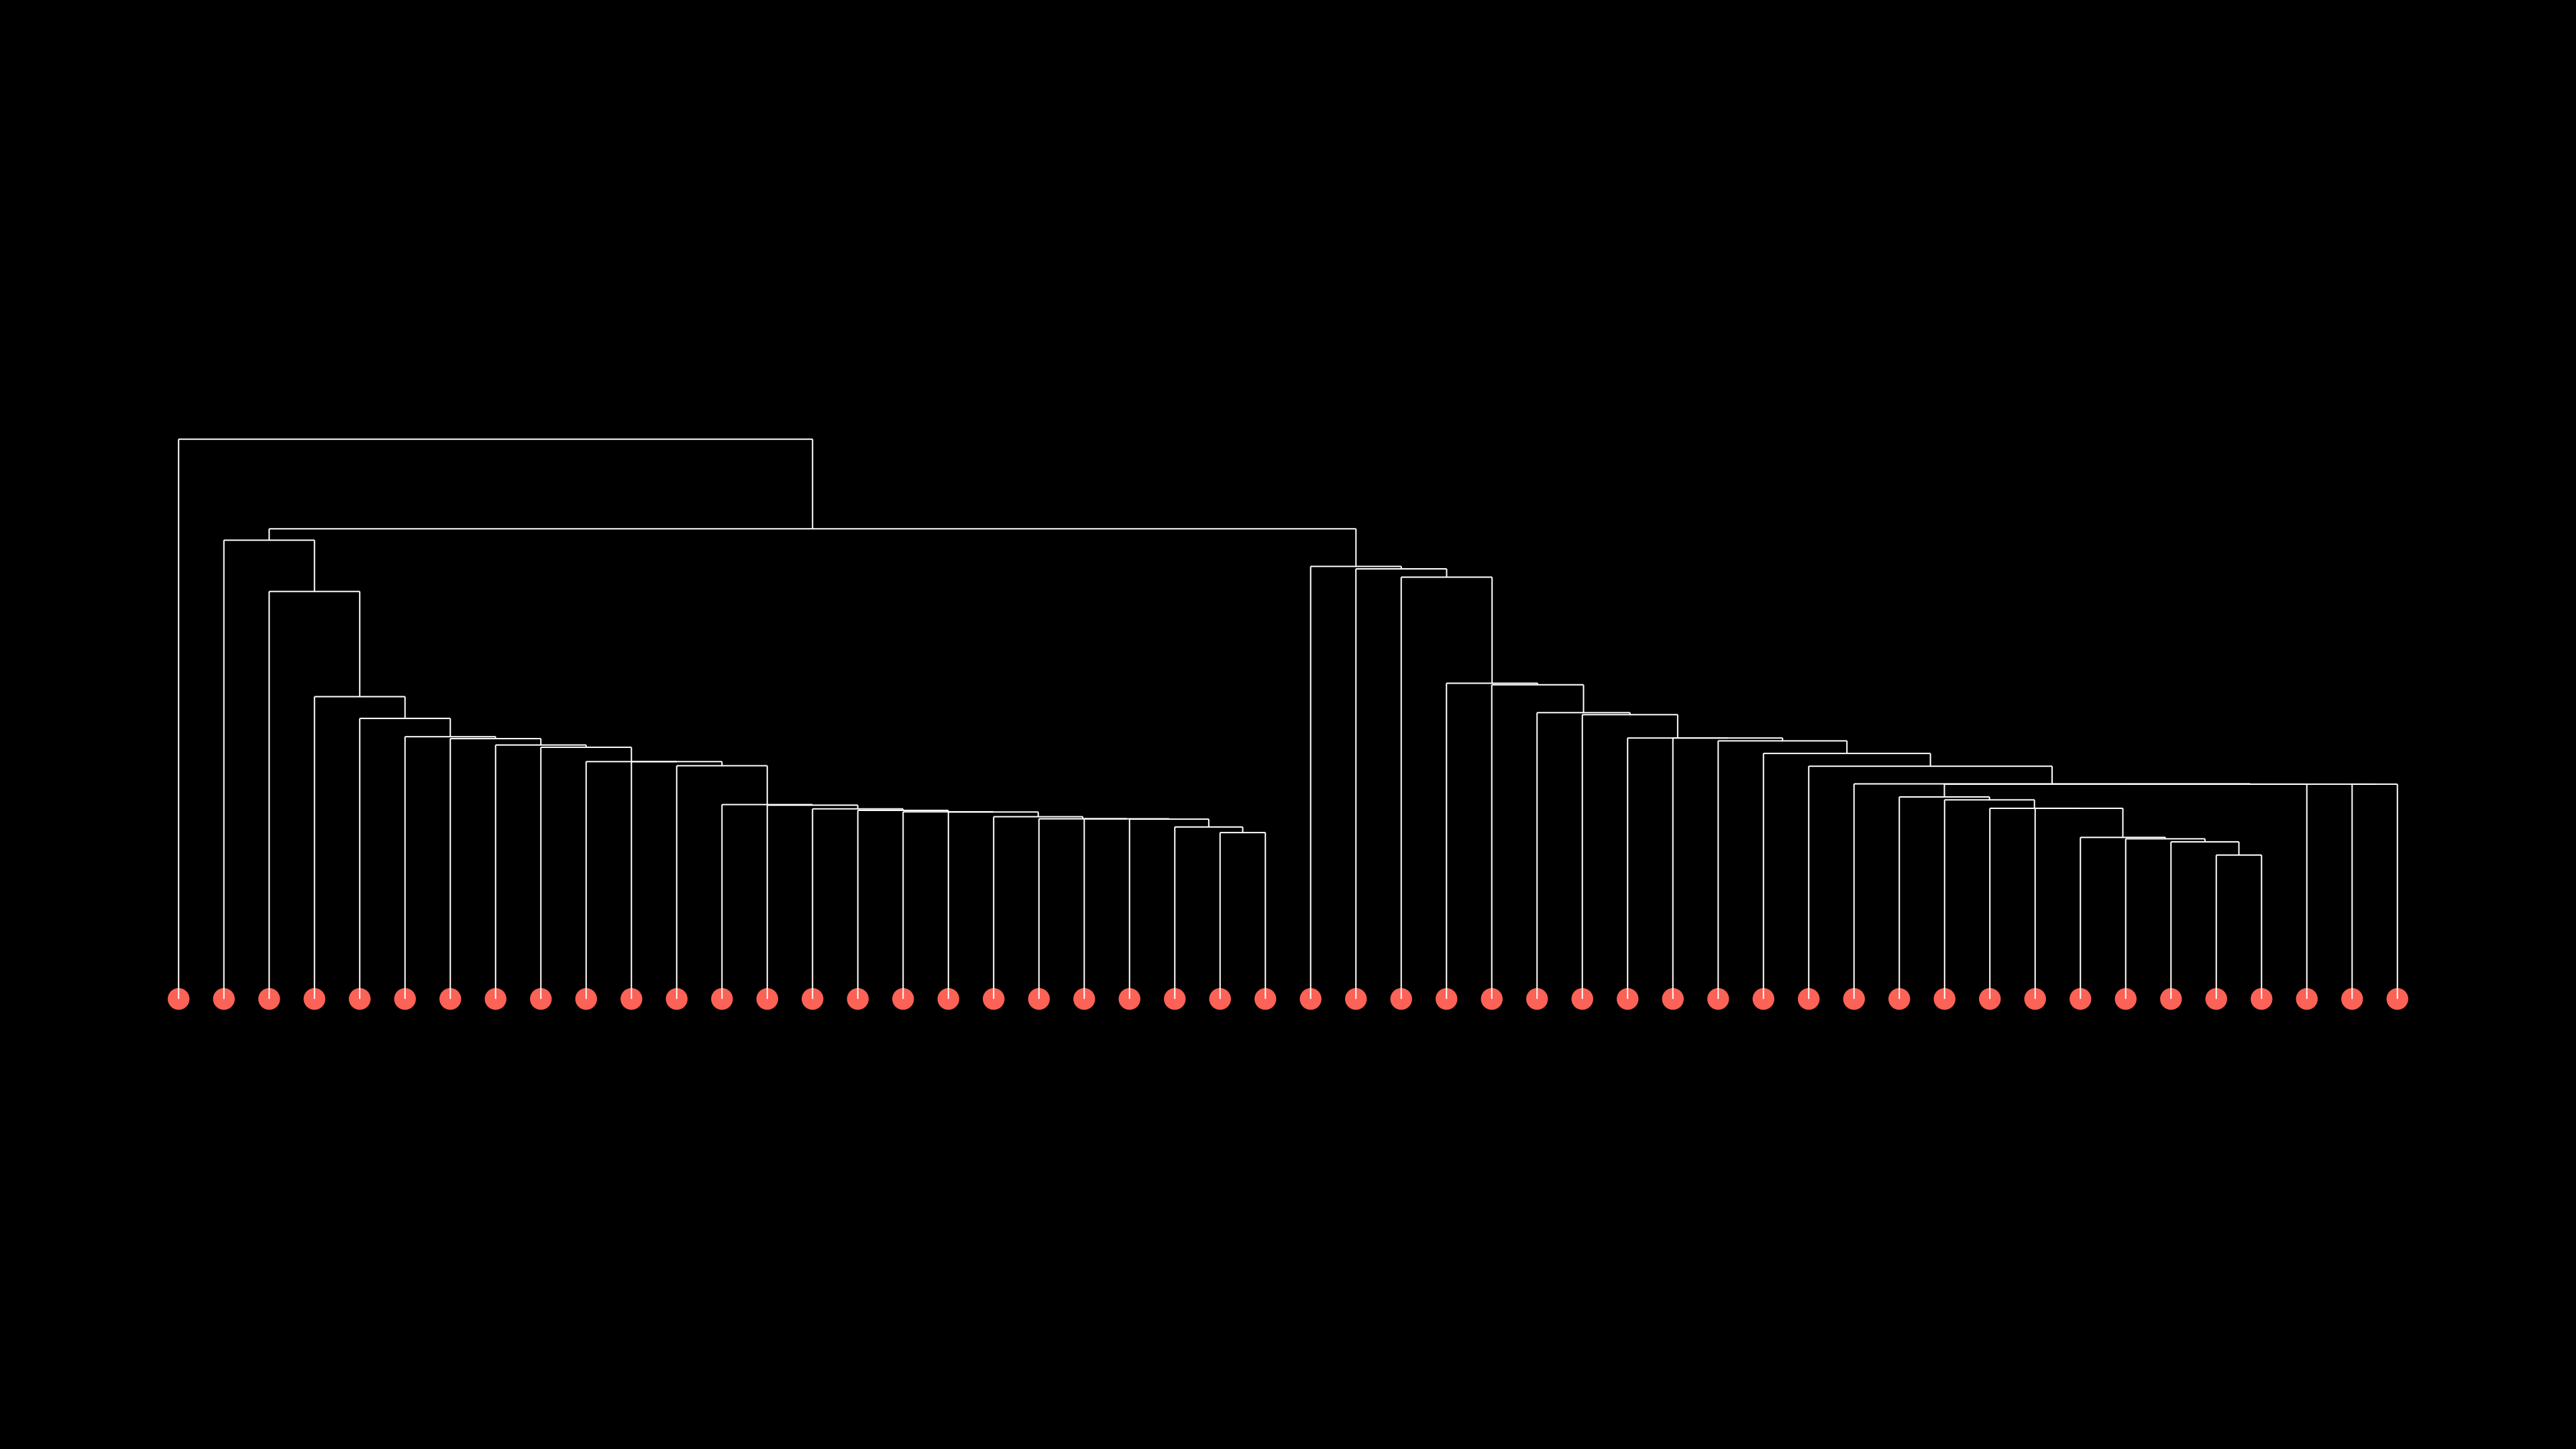

In [21]:
%%manim $paramss
plt.rcParams['figure.dpi'] = 300

In [25]:
name = 'Condensed_Graph'
paramsc = f'-v WARNING -ql --progress_bar leave {name}'
paramss = f'-v WARNING -s -qk --disable_caching --progress_bar leave {name}'

plot_data       = condensed_tree.get_plot_data()
bar_centers     = plot_data['bar_centers']
bar_tops        = plot_data['bar_tops']
bar_bottoms     = plot_data['bar_bottoms']
bar_widths      = plot_data['bar_widths']
line_xs         = plot_data['line_xs']
line_ys         = plot_data['line_ys']
cluster_bounds  = plot_data['cluster_bounds']


class Condensed_Graph(Scene):

    @lg.catch
    def construct(self):

        bars = VGroup()
        bar_clusters = {}

        scale_m = 25

        max_width = max(bar_widths[:-1]) / scale_m
        min_width = min(bar_widths) / scale_m

        def get_bar(idx):
            width = bar_widths[idx] / scale_m
            height = (bar_tops[idx] - bar_bottoms[idx]) / (scale_m + 35)

            center_id = bar_centers[idx]
            center_x  = -center_id / scale_m
            center_y  = height

            return Rectangle(
                height = height,
                width  = width,
                color  = interpolate_color(YELLOW_D, RED, min((width - min_width) / (max_width - min_width), 1)),
                fill_opacity = 1,
            ), center_id, center_x, center_y
        
        for idx in range(len(bar_centers))[:-1]:

            bar, center_id, center_x, center_y = get_bar(idx)

            if center_id not in bar_clusters:
                bar_clusters[center_id] = VGroup()
            bar_group = bar_clusters[bar_centers[idx]]

            if len(bar_group) == 0:
                bar.move_to([center_x, center_y, 0])
                bar_group.add(bar)

            else:
                bar.next_to(bar_group[-1], DOWN * bar_group[-1].height/2, buff=0)
                bar_group.add(bar)
            
            bars.add(bar)
        
        # Top bar
        bar, center_id, center_x, center_y = get_bar(-1)
        bar.move_to([center_x, (center_y - bar.height)/2, 0])
        bars.add(bar)
        bars.move_to(ORIGIN).scale(1)

        self.play(AnimationGroup(
            *[Create(obj) for obj in bars], lag_ratio=0.05
        ))

        # line = Line(LEFT*3, RIGHT*3).move_to(bars.get_edge_center(UP))
        # self.play(Create(line))
        # self.wait()

        # def opacity_updater(obj):
        #     if obj.get_center()[1] > line.get_center()[1]:
        #         obj.set_opacity(0)
        #     else:
        #         obj.set_opacity(1)

        # for id in range(len(bars)):

        #     bars[id].add_updater(opacity_updater)
        
        # self.play(line.animate.shift(DOWN*4))

        for idx in bar_clusters:
            grp = bar_clusters[idx]

            if len(list(grp)) > 1:
                rect = SurroundingRectangle(grp, buff=0.1)
                self.play(Create(rect))

        self.wait()

In [26]:
%%manim $paramsc
plt.rcParams['figure.dpi'] = 300

Animation 2: Create(SurroundingRectangle): 100%|##########| 15/15 [00:00<00:00, 118.78it/s]


In [ ]:
plot_data       = condensed_tree.get_plot_data()
bar_centers     = plot_data['bar_centers']
bar_tops        = plot_data['bar_tops']
bar_bottoms     = plot_data['bar_bottoms']
bar_widths      = plot_data['bar_widths']
line_xs         = plot_data['line_xs']
line_ys         = plot_data['line_ys']
cluster_bounds  = plot_data['cluster_bounds']

In [53]:
name = 'Color_Points'
params = f"-v WARNING -ql --disable_caching --progress_bar leave {name}"
paramsc = f"-v WARNING -ql --progress_bar leave {name}"
paramss = f"-v WARNING -s -qk --disable_caching --progress_bar leave {name}"

class Color_Points(ZoomedScene):

    @lg.catch
    def construct(self):

        dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')

        title = Title("HDBSCAN", color=WHITE, match_underline_width_to_text=True).scale(1.5).to_edge(UP)
        
        # Creating Title and Algorithm
        def create_title_and_algorithm():

            # Print the Algorithm
            algorithm = Text("Algorithm", color=RED).scale(.6).next_to(title, DOWN*3)
            l1 = Line(LEFT*3, RIGHT*4, color=RED)
            l2 = Line(LEFT*3, RIGHT*4, color=RED)
            title_grp = VGroup(l1, algorithm, l2).arrange(DOWN, buff=0.1)
            algorithm.shift(LEFT)
            l1.shift(LEFT)
            l2.shift(LEFT)

            # Steps
            step1 = Tex(r'$1.$ Compute the core distance.', color=BLUE_D).scale(0.55).next_to(title_grp, DOWN)
            step2 = Tex(r'$2.$ Compute an Mutual Reachability Distance (MRD).', color=BLUE_D).scale(0.55)
            step3 = Tex(r'$3.$ Build a Minimum Spanning Tree, using MRD', color=BLUE_D).scale(0.55)
            step4 = Tex(r'$4.$ Construct Cluster Hierarchy using Single Linkage', color=BLUE_D).scale(0.55)
            step5 = Tex(r'$5.$ Condense the clusters using $k$', color=BLUE_D).scale(0.55)
            step6 = Tex(r'$6.$ Extract clusters', color=BLUE_D).scale(0.55)

            steps = VGroup(step1, step2, step3, step4, step5, step6).arrange(DOWN, center=False, aligned_edge=LEFT, buff=0.3)

            algorithm_group = VGroup(title_grp, steps).shift(UP)
            steps.shift(LEFT*1.5)
            algorithm_group.shift(RIGHT)

            return title, title_grp, steps ,algorithm_group
        
        title, title_grp, steps ,algorithm_group = create_title_and_algorithm()
        algorithm_group.to_edge(LEFT).scale(0.8).shift(UP+LEFT)
        title.to_corner(UL)

        # Input Dots
        def input_dots(test_data):

            dots = VGroup()
            p_scale = 8
            for  idx, (x, y) in enumerate(test_data):
                dot = Dot(point=[x*p_scale, y*p_scale, 0], color=WHITE).scale(0.5)
                dots.add(dot)

            dots.move_to(ORIGIN)
            background = ScreenRectangle(aspect_ratio=1)
            background.set(height=6.5)
            background.set_fill(BLACK, 1)
            background.set_stroke(width=0)
            background.move_to(ORIGIN)
            dots.add_to_back(background)
            dots.shift(RIGHT*3.5)
            
            return dots
        
        dots = input_dots(test_data)
        
        # Focus on step
        def focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(YELLOW).scale(1.2).shift(RIGHT*.3)
        
        # Remove focus on step
        def remove_focus_on_step(steps, step_idx):
            step = steps[step_idx]
            return step.animate.set_color(BLUE_D).scale(1/1.2).shift(LEFT*.3)

        # clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', gen_min_span_tree=True)
        # clusterer.fit(test_data)
        # min_spanning_tree = clusterer.minimum_spanning_tree_
        # min_spanning_array = min_spanning_tree.to_numpy()[:,:2]
        # dist_array = min_spanning_tree.to_numpy()[:,2]

        def draw_tree(dots, min_spanning_array, dist_array):

            # Create minimum spanning tree
            global mst
            mst = []
            max_len  = max(dist_array)
            mean_len = np.mean(dist_array)
            min_len  = min(dist_array)
            for pt in min_spanning_array:
                c = interpolate_color(YELLOW, RED, min(dist_array[int(pt[0])]/max_len, 1))
                line = Line(dots[int(pt[0])+1].get_center(), dots[int(pt[1])+1].get_center(), color=c)
                mst.append(line)
            
            self.play(AnimationGroup(*[Create(line) for line in mst]))

        def perform_step_4(steps, dots):
            linkage = single_linkage_tree.to_numpy()
            dend_dict = Dendrogram(single_linkage_tree.to_numpy(), get_leaves=True, no_plot=True)
            icoord = dend_dict['icoord']
            dcoord = dend_dict['dcoord']
            ivl    = dend_dict['ivl']
            heights = linkage[:,2]
            max_height = max(heights)
            min_height = min(heights)

            # self.play(remove_focus_on_step(steps, 2), focus_on_step(steps, 3))
            self.wait(2)
            lines       = []
            global dendrogram
            dendrogram  = VGroup()
            m           = 10
            n           = 60

            label_position_x = set()
            label_position_y = set()
            dendrogram_dots  = []

            for idx in range(len(ivl)-1):

                x1, x2, x3, x4 = icoord[idx]
                y1, y2, y3, y4 = dcoord[idx]
                lable          = ivl[idx]

                x1, x2, x3, x4 = x1/n, x2/n, x3/n, x4/n
                y1, y2, y3, y4 = y1*m, y2*m, y3*m, y4*m

                c = WHITE

                line1 = Line([x1, y1, 0], [x2, y2, 0], color=c, stroke_width=0.75)
                line2 = Line([x2, y2, 0], [x3, y3, 0], color=c, stroke_width=0.75)
                line3 = Line([x3, y3, 0], [x4, y4, 0], color=c, stroke_width=0.75)
                l1_idx = len(lines) - 3
                l2_idx = len(lines) - 2
                l3_idx = len(lines) - 1
                lines.extend([line1, line2, line3])

                if y1 == 0:
                    label_position_x.add(x1)
                    label_position_y.add(y1)
                    dendrogram_dots.append(Dot(point=[x1, y1, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])

                if y4 == 0:
                    label_position_x.add(x4)
                    label_position_y.add(y4)
                    dendrogram_dots.append(Dot(point=[x4, y4, 0], color=RED).scale(0.5))
                    dendrogram.add(dendrogram_dots[-1])

                dendrogram.add(line1, line2, line3)

            dendrogram.scale(1.5).move_to(ORIGIN)#.shift(DOWN*2.5 + LEFT*.75)

            dots_dict = {}
            for idx, dot in enumerate(dendrogram_dots):
                dots_dict[dot] = dot.get_center()

            sorted_dots_dict = {k: v for k, v in sorted(dots_dict.items(), key=lambda item: item[1][0])}
            sorted_dendrogram_dots = {}
            for idx, dot in enumerate(sorted_dots_dict.keys()):
                sorted_dendrogram_dots[dot] = dend_dict['leaves'][idx]

            self.play(
                AnimationGroup(*[Create(obj) if not isinstance(obj, Dot) else TransformFromCopy(dots[sorted_dendrogram_dots[obj] + 1], obj)for obj in dendrogram], lag_ratio=0.075)
            )

            self.wait(2)
        

        plot_data       = condensed_tree.get_plot_data()
        bar_centers     = plot_data['bar_centers']
        bar_tops        = plot_data['bar_tops']
        bar_bottoms     = plot_data['bar_bottoms']
        bar_widths      = plot_data['bar_widths']
        line_xs         = plot_data['line_xs']
        line_ys         = plot_data['line_ys']
        cluster_bounds  = plot_data['cluster_bounds']
        
        def perform_step_5(steps, dots):

            # self.play(focus_on_step(steps, 4), remove_focus_on_step(steps, 3))
            global bars, bar_clusters
            bars = VGroup()
            bar_clusters = {}

            scale_m = 25

            max_width = max(bar_widths[:-1]) / scale_m
            min_width = min(bar_widths) / scale_m

            def get_bar(idx):
                width = bar_widths[idx] / scale_m
                height = (bar_tops[idx] - bar_bottoms[idx]) / (scale_m + 40)

                center_id = bar_centers[idx]
                center_x  = - center_id / scale_m
                center_y  = height

                return Rectangle(
                    height = height,
                    width  = width,
                    color  = interpolate_color(YELLOW_D, RED, min((width - min_width) / (max_width - min_width), 1)),
                    fill_opacity = 1,
                ), center_id, center_x, center_y
            
            for idx in range(len(bar_centers))[:-1]:

                bar, center_id, center_x, center_y = get_bar(idx)

                if center_id not in bar_clusters:
                    bar_clusters[center_id] = VGroup()
                bar_group = bar_clusters[bar_centers[idx]]

                if len(bar_group) == 0:
                    bar.move_to([center_x, center_y, 0])
                    bar_group.add(bar)

                else:
                    bar.next_to(bar_group[-1], DOWN * bar_group[-1].height/2, buff=0)
                    bar_group.add(bar)
                
                bars.add(bar)
            
            # Top bar
            bar, center_id, center_x, center_y = get_bar(-1)
            bar.move_to([center_x, (center_y - bar.height)/2, 0])
            bars.add(bar)

            global dendrogram
            bars.move_to(dendrogram.get_center()).scale(1)

            revel_line = Line(LEFT*4.5, RIGHT*4.5, stroke_width=2).move_to(bars.get_edge_center(UP))

            def condensed_graph_updater(obj):
                
                if obj.get_center()[1] < revel_line.get_center()[1]:
                    obj.set_opacity(0)
                else:
                    obj.set_opacity(1)
            
            def dendrogram_updater(obj):

                if isinstance(obj, Dot):
                    idx  = list(dendrogram).index(obj)
                    line = dendrogram[idx + 1]
                    y1   = line.get_start()[1]
                    y2   = line.get_end()[1]
                    y    = max(y1, y2)

                else:
                    y1 = obj.get_start()[1]
                    y2 = obj.get_end()[1]
                    y  = max(y1, y2)
                
                if y > revel_line.get_center()[1]:
                    obj.set_opacity(0)
                else:
                    obj.set_opacity(1)

            for obj in dendrogram:
                obj.add_updater(dendrogram_updater)

            for obj in bars:
                obj.set_opacity(0)
                obj.add_updater(condensed_graph_updater)            

            self.add(bars)

            self.wait()
            self.play(Create(revel_line))

            self.wait(2)

            self.play(revel_line.animate.move_to(np.array(bars.get_edge_center(DOWN)) + np.array([0, 0.1, 0])), run_time=5)

            self.wait()
            self.play(Uncreate(revel_line))
            self.remove(dendrogram)
        

        # Step 6
        def perform_step_6(steps, dots):
                
            # self.play(focus_on_step(steps, 5), remove_focus_on_step(steps, 4))
            self.wait(2)

            global bars, bar_clusters

            rects = []
            for idx in bar_clusters:
                grp = bar_clusters[idx]

                if len(list(grp)) > 1:
                    rect = SurroundingRectangle(grp, buff=0.1)
                    self.play(Create(rect))
                    rects.append(rect)

            self.play(AnimationGroup(
                *[Uncreate(line) for line in mst],
                FadeOut(bars),
                *[Uncreate(rect) for rect in rects]
            ))
            self.wait()

            # Get labels
            labels = clusterer.labels_
            print(list(labels))
            color = [RED, YELLOW, LIGHT_GRAY]

            self.play(
                AnimationGroup(*[Flash(dots[idx1 + 1]) for idx1 in range(len(labels))], lag_ratio=0.075),
                AnimationGroup(*[dots[idx2].animate.set_color(color[labels[idx2-1]]) for idx2 in range(1, len(dots))], lag_ratio=0.075)
            )

            self.wait()

        self.add(dots, algorithm_group, title)
        self.wait()
        # perform_step_4(steps, dots)
        perform_step_5(steps, dots)
        perform_step_6(steps, dots)
        self.wait(2)

Animation 10: AnimationGroup(Group): 100%|##########| 1/1 [00:00<00:00, 30.86it/s]


[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, -1, 0, 1, 0, 1, 0, 0, 1]


Animation 12: AnimationGroup(Group), etc.: 100%|##########| 1/1 [00:00<00:00,  8.65it/s]


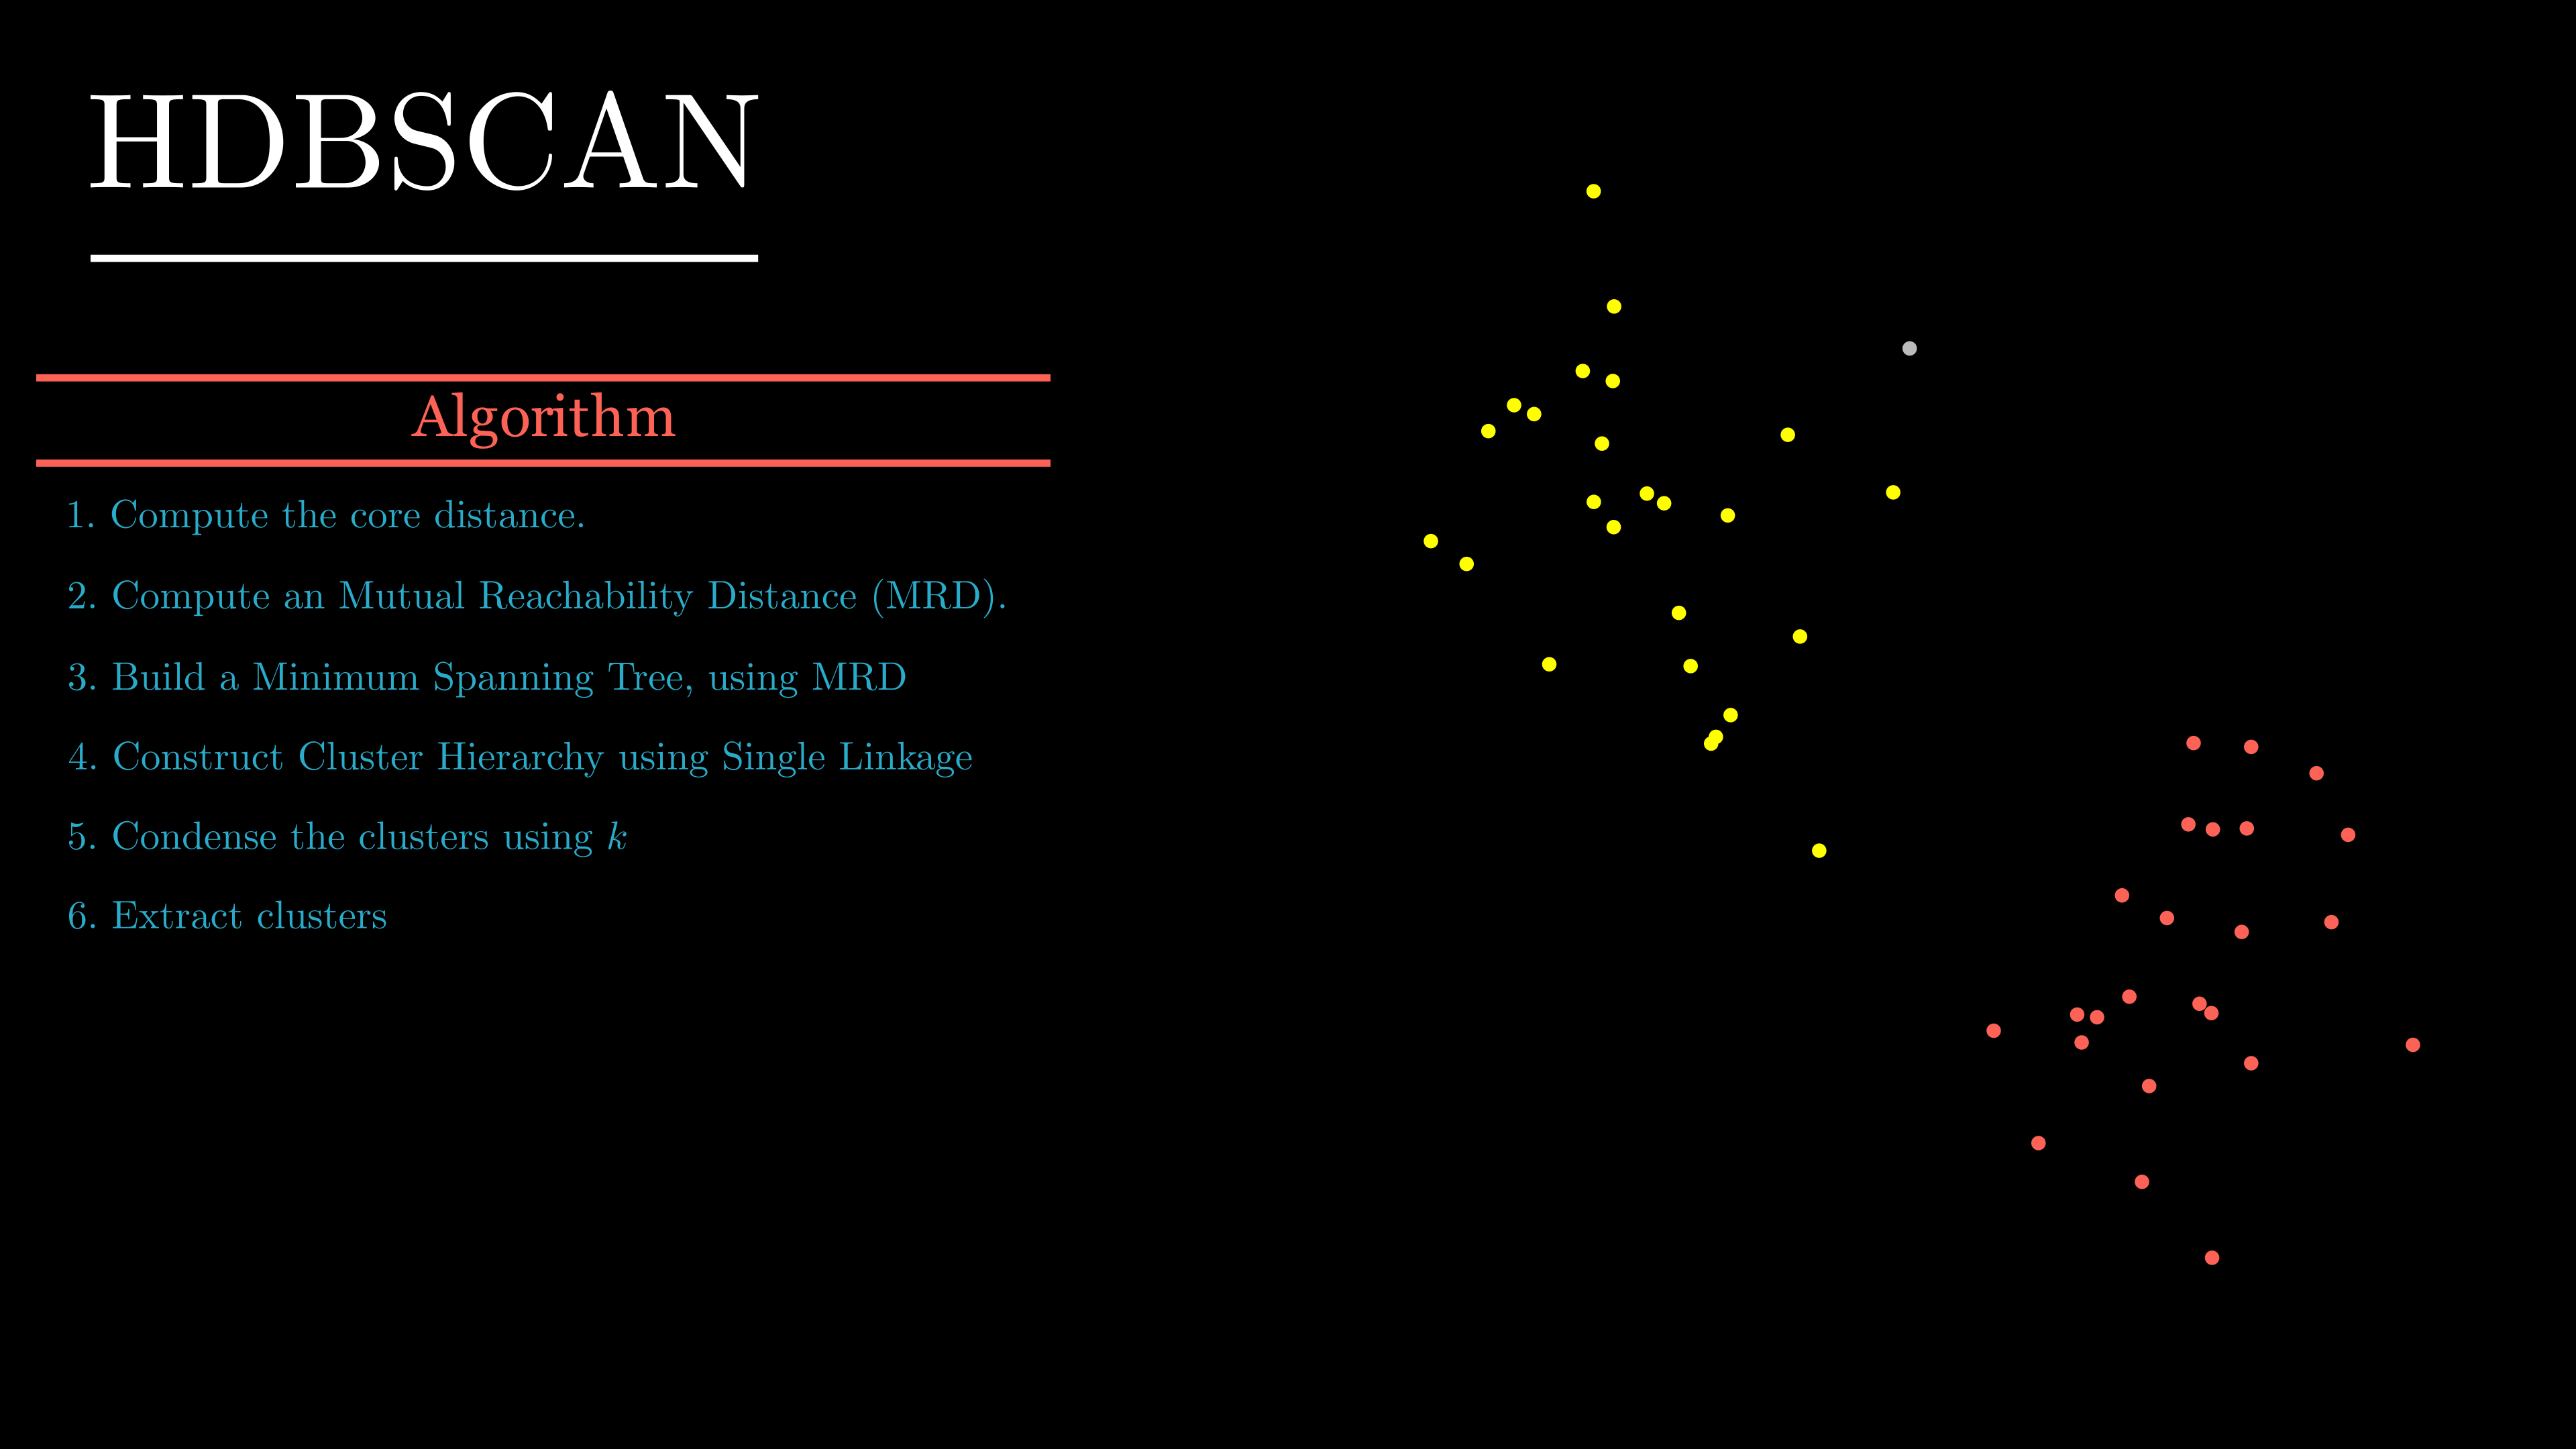

In [54]:
%%manim $paramss
plt.rcParams['figure.dpi'] = 300

<AxesSubplot: ylabel='distance'>

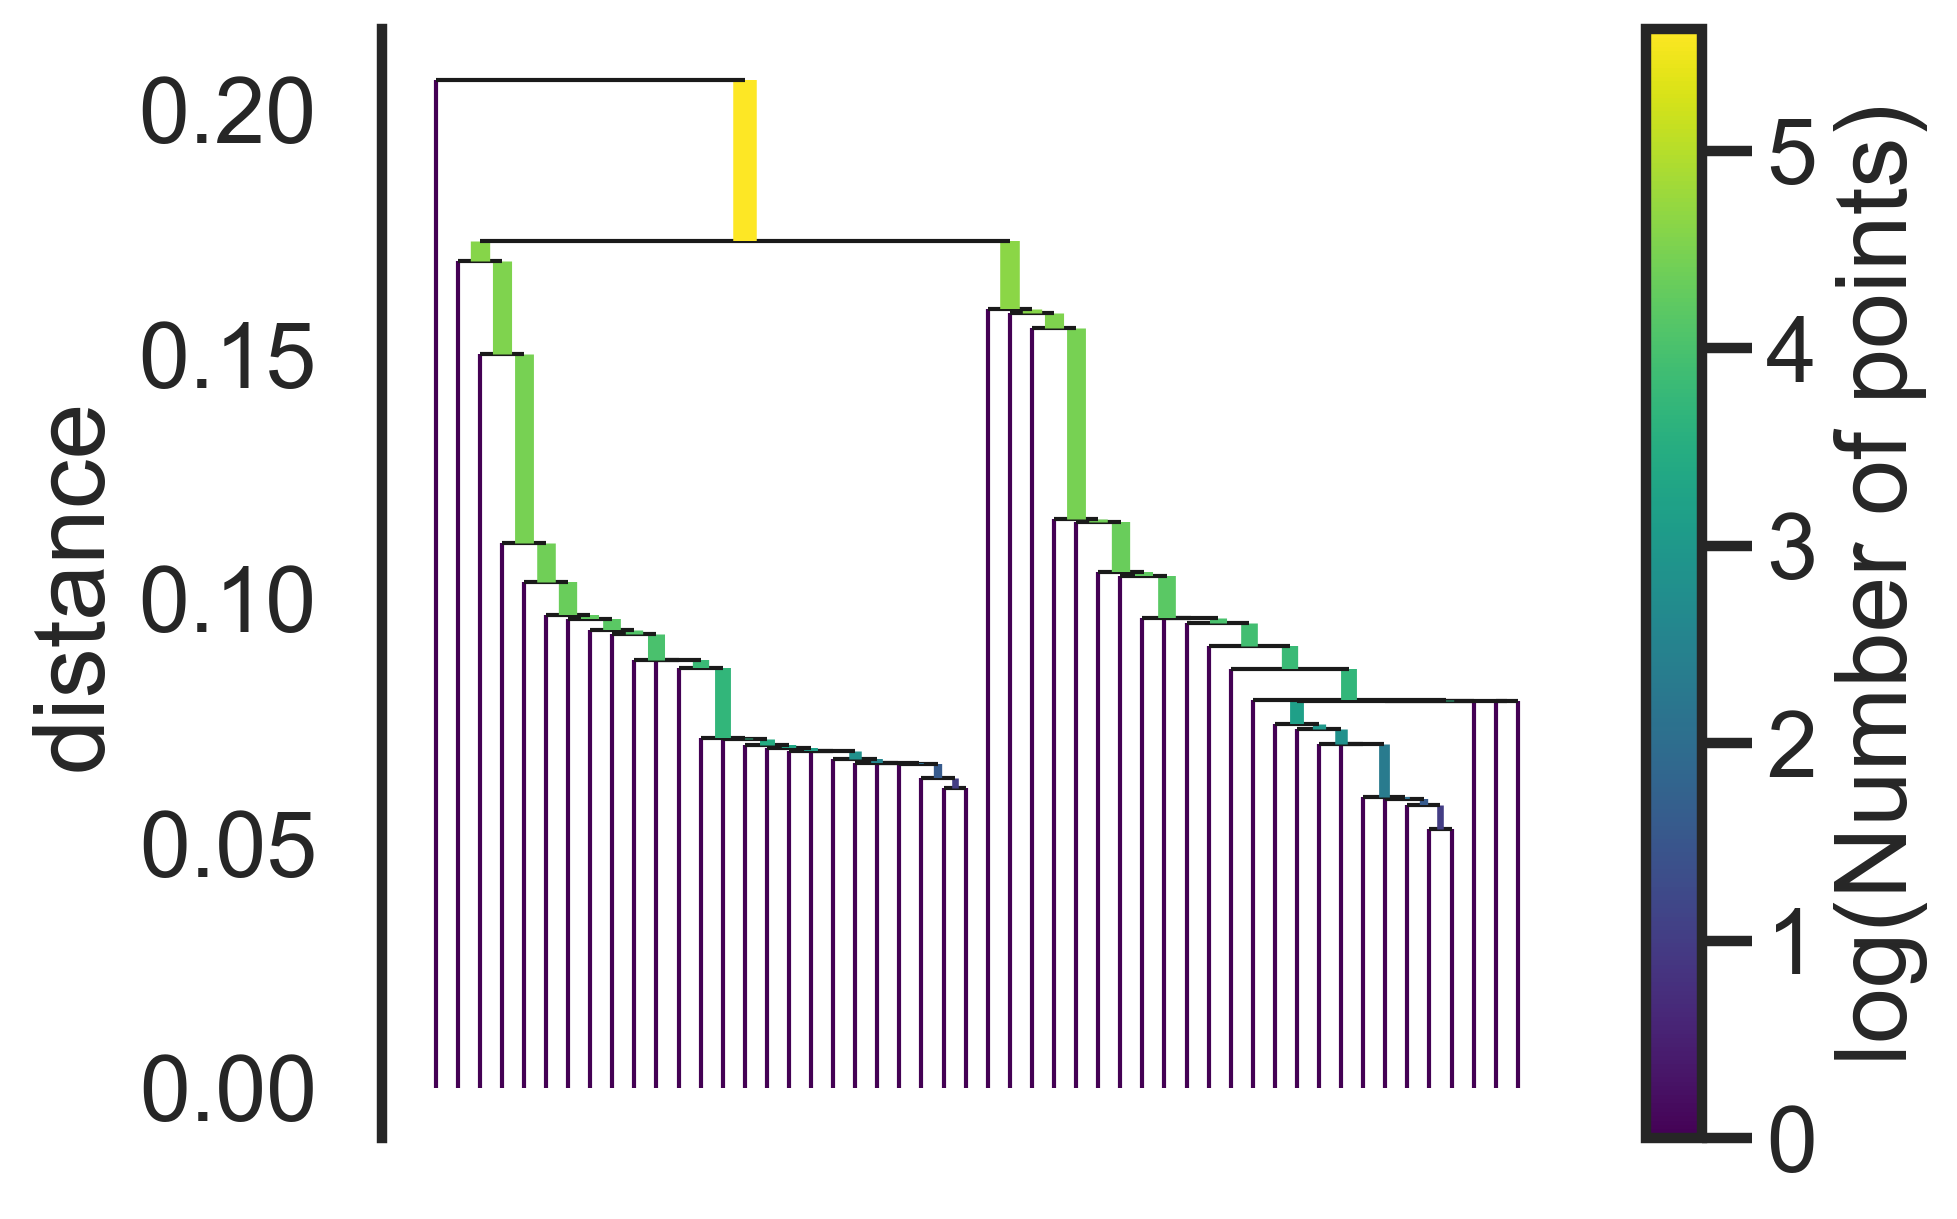

In [15]:
single_linkage_tree.plot()

<AxesSubplot: ylabel='$\\lambda$ value'>

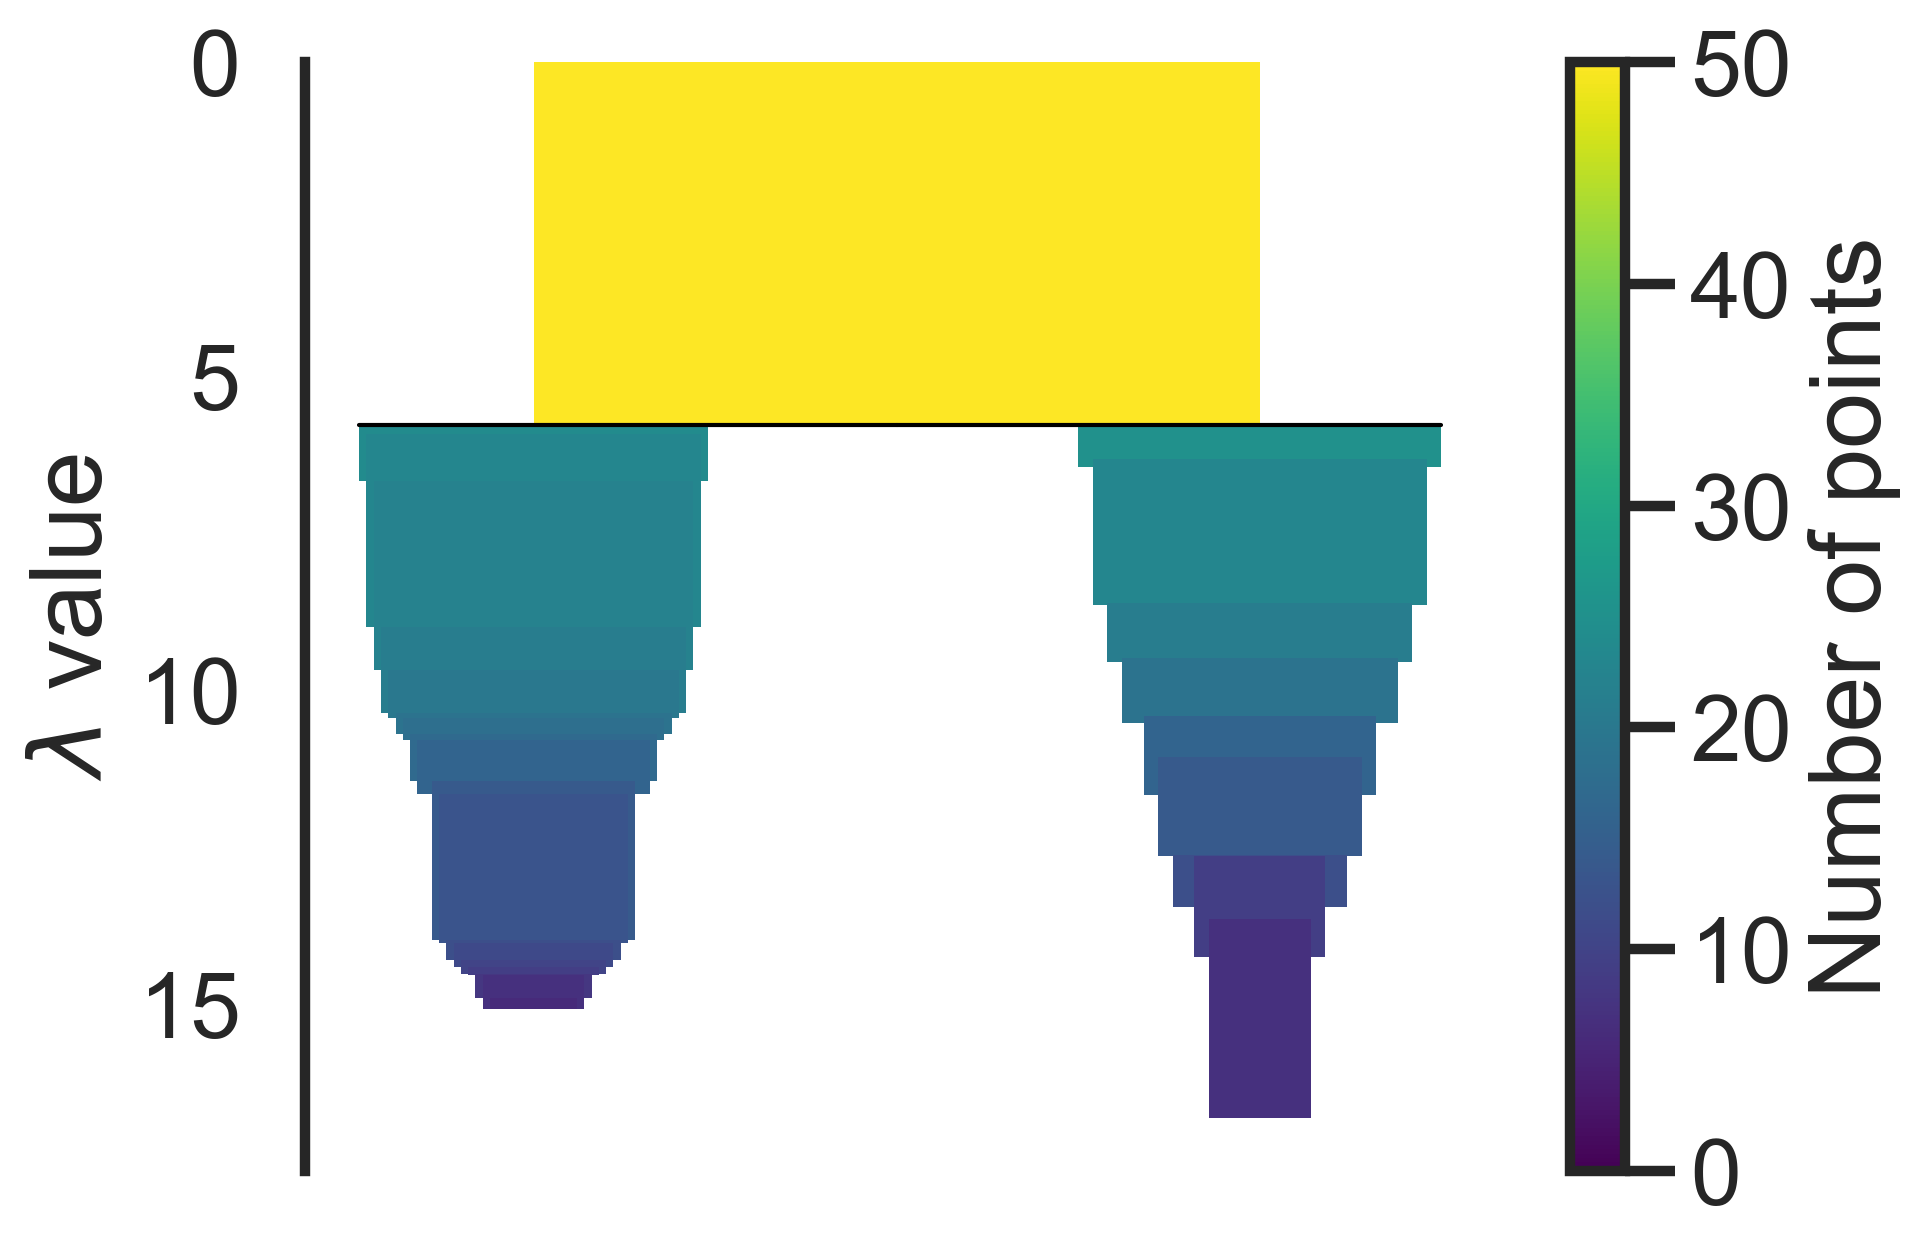

In [24]:
condensed_tree.plot()

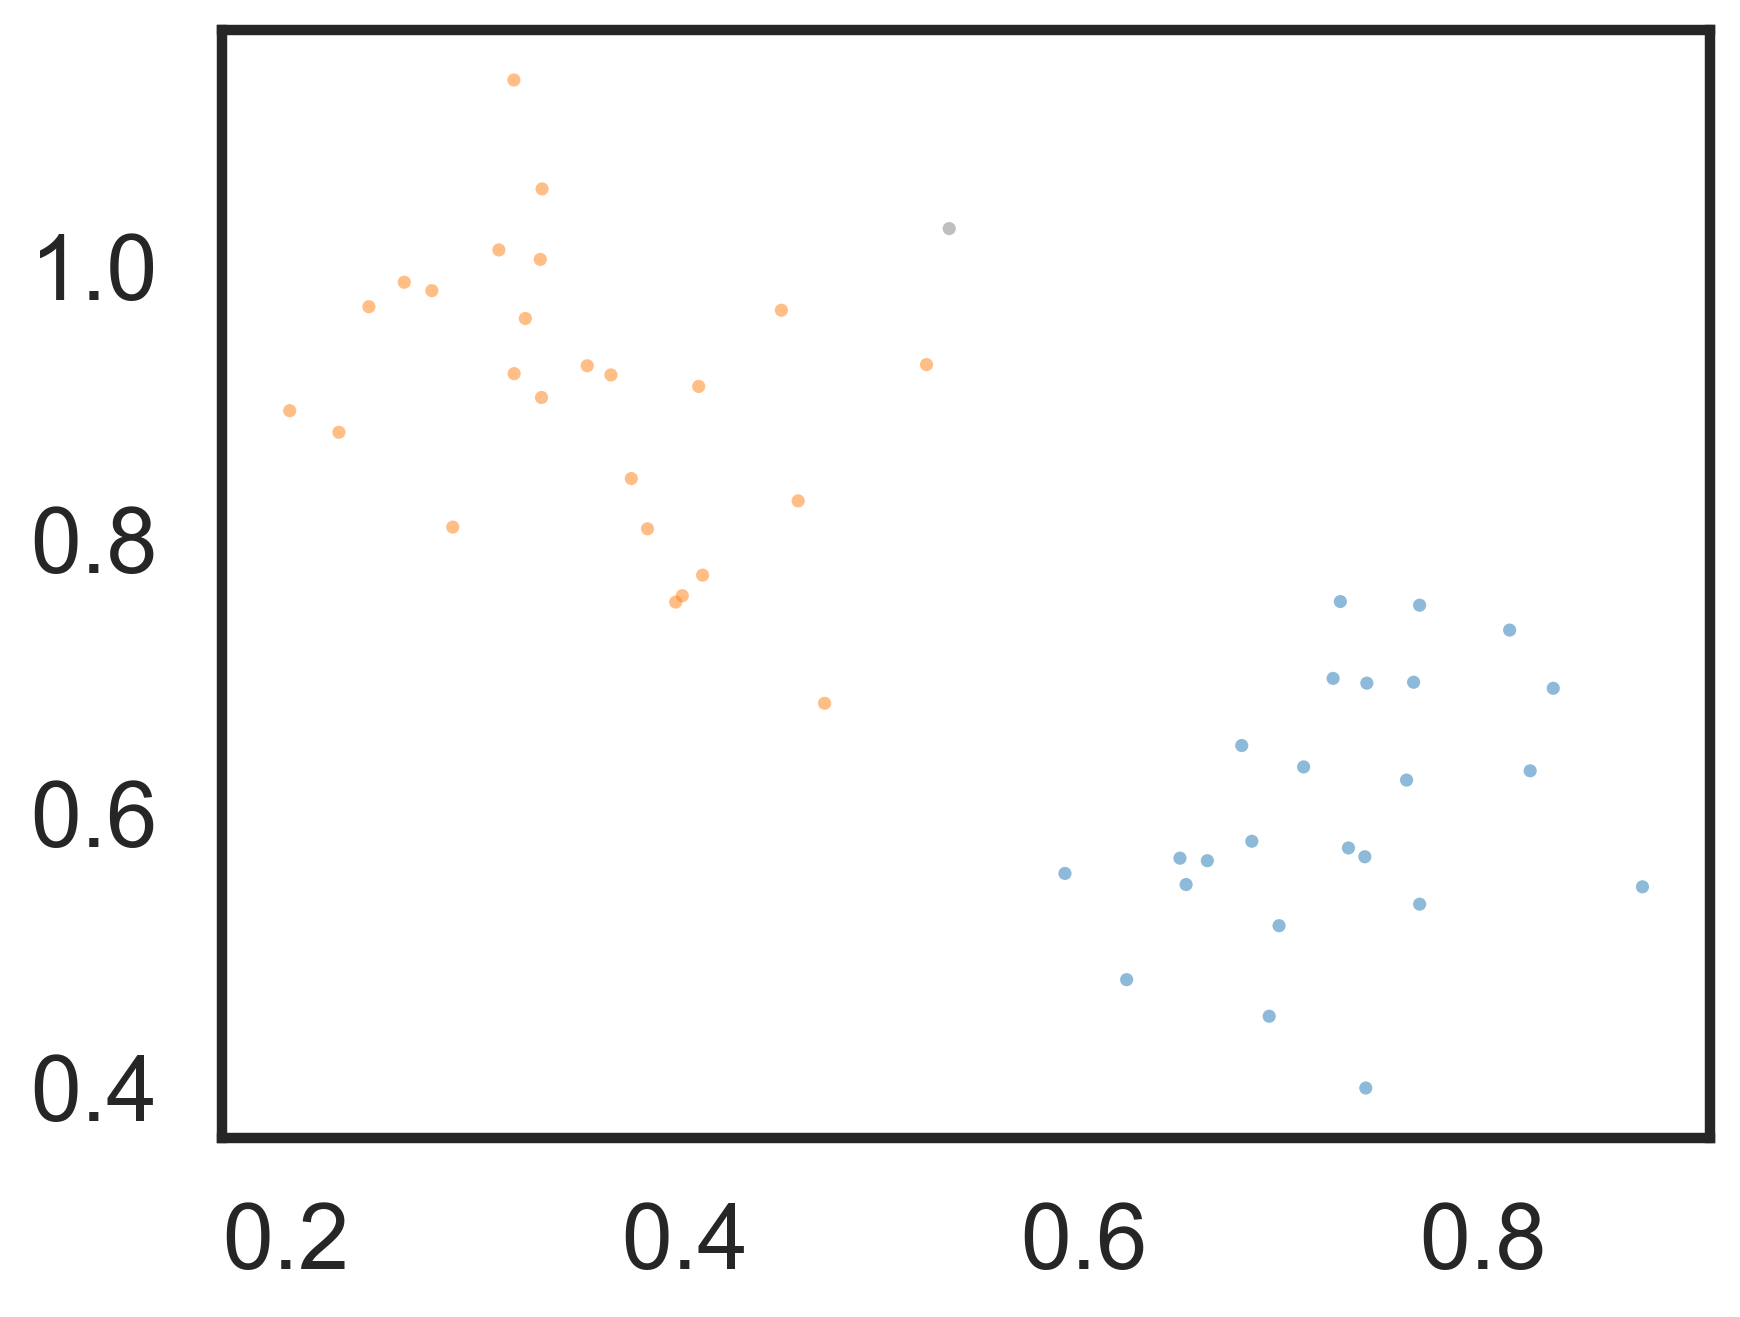

In [11]:
plot_kwds = {'alpha' : 0.5, 's' : 10, 'linewidths':0}
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], 1) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
# cluster_colors = 
plt.scatter(test_data[:,0], test_data[:,1], c=cluster_colors, **plot_kwds)

In [52]:
clusterer.labels_, np.array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, -1, 0, 1, 0, 1, 0, 0, 1])

(array([ 0,  1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,
         0,  1,  0,  0,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  1,  0,
         0,  1,  0,  0,  0,  1,  0,  1, -1,  0,  1,  0,  1,  0,  0,  1],
       dtype=int64),
 array([ 0,  1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,
         0,  1,  0,  0,  1,  1,  1,  0,  1,  0,  0,  1,  0,  0,  1,  1,  0,
         0,  1,  0,  0,  0,  1,  0,  1, -1,  0,  1,  0,  1,  0,  0,  1]))

# Real Test Example

In [280]:
name = 'Final_Example'
params = f"-v WARNING -ql --disable_caching --progress_bar leave {name}"
paramsc = f"-v WARNING -ql --progress_bar leave {name}"
paramssk = f"-v WARNING -s -qk --disable_caching --progress_bar leave {name}"
paramssl = f"-v WARNING -s -ql --progress_bar leave {name}"

class Final_Example(ZoomedScene):

    # Generate required data
    def generate_data(self):

        print('Started Data Generation')
        start_time = perf_counter()

        # Import the data
        self.data_points = np.load("data\clusterable_data.npy")
        self.grp_ids          = [(0, 400), (400, 600), (600, 800), (800, 1200), (1200, 1600), (1600, 1900), (1900, 2309)]

        # Perform the HDBSCAN on the data
        self.k         = 15
        self.clusterer = hdbscan.HDBSCAN(min_cluster_size=self.k, gen_min_span_tree=True)
        self.clusterer.fit(self.data_points)

        # Get the required data from the clusterer
        self.labels              = self.clusterer.labels_
        self.probabilities       = self.clusterer.probabilities_
        self.min_spanning_tree   = self.clusterer.minimum_spanning_tree_
        self.single_linkage_tree = self.clusterer.single_linkage_tree_
        self.condensed_tree      = self.clusterer.condensed_tree_

        # Data for Step 1: Computing the Core points
        self.distance_matrix = hdbscan.validity.pairwise_distances(self.data_points, metric='euclidean')
        self.core_radii      = []
        self.core_circles    = []
        self.sorted_dots     = []

        # Calculations for Dendrogram
        self.linkage     = self.single_linkage_tree.to_numpy()
        self.dend_dict   = Dendrogram(self.linkage, get_leaves=True, no_plot=True)
        self.icoord      = self.dend_dict['icoord']
        self.dcoord      = self.dend_dict['dcoord']
        self.ivl         = self.dend_dict['ivl']
        self.heights     = self.linkage[:,2]
        self.max_height  = max(self.heights)
        self.min_height  = min(self.heights)

        # Calculations for Condensed Tree
        plot_data            = self.condensed_tree.get_plot_data()
        self.bar_centers     = plot_data['bar_centers']
        self.bar_tops        = plot_data['bar_tops']
        self.bar_bottoms     = plot_data['bar_bottoms']
        self.bar_widths      = plot_data['bar_widths']
        self.line_xs         = plot_data['line_xs']
        self.line_ys         = plot_data['line_ys']
        self.cluster_bounds  = plot_data['cluster_bounds']

        print('Data Generation Completed')
        print(f'Time Taken: {perf_counter() - start_time}\n\n')

    # Creating Title and Algorithm
    def create_title_and_algorithm(self):

        # Steps
        step0 = Tex(r'Step $0:$ Import the data points', color=BLUE_D).scale(0.55).to_edge(UP)
        step1 = Tex(r'Step $1:$ Compute the core distance', color=BLUE_D).scale(0.55).to_edge(UP)
        step2 = Tex(r'Step $2:$ Compute an Mutual Reachability Distance (MRD)', color=BLUE_D).scale(0.55).to_edge(UP)
        step3 = Tex(r'Step $3:$ Build a Minimum Spanning Tree, using MRD', color=BLUE_D).scale(0.55).to_edge(UP)
        step4 = Tex(r'Step $4:$ Construct Cluster Hierarchy using Single Linkage', color=BLUE_D).scale(0.55).to_edge(UP)
        step5 = Tex(r'Step $5:$ Condense the clusters using $k$', color=BLUE_D).scale(0.55).to_edge(UP)
        step6 = Tex(r'Step $6:$ Extract clusters', color=BLUE_D).scale(0.55).to_edge(UP)

        self.steps = VGroup(step0, step1, step2, step3, step4, step5, step6)

    # Step 0: Input Data
    def input_dots(self):

        # VGroup to store all the dots
        self.dots = VGroup()

        # The scale value for the dots position
        x_scale = 12
        y_scale = 5

        # Position the dots and add them to the VGroup
        print('Generating Dots')
        start_time = perf_counter()
        for  idx, (x, y) in enumerate(self.data_points):
            dot = Dot(point=[x*x_scale, y*y_scale, 0], color=WHITE, radius=0.025).scale(0.5)
            self.dots.add(dot)
        print('Dots Generated')
        print(f'Time Taken: {perf_counter() - start_time}\n\n')
        
        # Move the sots to the center of the screen
        self.dots.move_to(ORIGIN)
        background = ScreenRectangle(aspect_ratio=1)
        background.set_fill(BLACK, 1)
        background.set_stroke(width=0)
        background.move_to(ORIGIN)
        self.dots.add_to_back(background)

        self.add(self.dots.submobjects[0])
        print('Shuffling the dots')
        start_time = perf_counter()
        np.random.seed(43)
        shuffled_ids = list(range(1, len(self.dots)))
        np.random.shuffle(shuffled_ids)
        print('Dots Shuffled')
        print(f'Time Taken: {perf_counter() - start_time}\n\n')

        print('Starting Dot Generation Animation')
        start_time = perf_counter()
        self.play(AnimationGroup(
            *[GrowFromCenter(self.dots[id]) for id in tqdm(shuffled_ids, desc='Generating Dots')],
            lag_ratio=0.005,
            rate_func=rate_functions.linear
        ))
        print('Dot Generation Animation Completed')
        print(f'Time Taken: {perf_counter() - start_time}\n\n')

    # Helping Function for Step 1:
    # Compute core circle for given point
    def get_core_circle(self, dot_idx):

        # Get the Distance of the given point from all other points
        # The id of given point in the distance matrix is 1 less than the id of the dot in the dots VGroup
        dists = self.distance_matrix[dot_idx - 1]
        pts = []

        # Find the kth nearest point to the given point
        while len(pts) <= self.k + 1:
            pt_idx = np.argmin(dists)
            pts.append(self.dots[pt_idx + 1])
            dists[pt_idx] = np.inf
        
        # The kth nearest point is the last point in the list
        pt = pts[-1]

        # Get the distance between the given point and the kth nearest point
        radius = euclidean(self.dots[dot_idx].get_center(), pt.get_center())
        core_circle = Circle(radius=radius, color=BLUE, fill_opacity=0.2, stroke_width=0.5).move_to(self.dots[dot_idx].get_center())

        self.core_radii.append(radius)
        self.core_circles.append(core_circle)
        self.sorted_dots.append(self.dots[dot_idx])
        return core_circle

    # Step 1: Compute the core distance
    def compute_core_distances(self, testing:bool = False):

            circles = []
            for dot_idx in tqdm(range(1, len(self.dots)), desc='Generating Core Circles'):
                circles.append(self.get_core_circle(dot_idx))

            for idx in tqdm(range(len(circles)), desc='Coloring the Core Circles'):
                c = interpolate_color(YELLOW, RED, min(1, ((self.core_radii[idx] - np.min(self.core_radii)) / np.mean(self.core_radii)) * 0.75))
                circles[idx].set_color(c)

            for start_id, end_id in self.grp_ids:
                print(f'\nGrouping {start_id} to {end_id}')

                if testing:
                    pass
                else:
                    self.play(
                        AnimationGroup(
                            *[Create(circle) for circle in tqdm(circles[start_id: end_id], desc=f'Core Circles[{start_id}:{end_id}]')],
                            lag_ratio=0.01,
                            rate_func=rate_functions.ease_in_out_quart
                        )
                    )
                self.wait()

                if testing:
                    [self.sorted_dots[idx].set_color(self.core_circles[idx].color) for idx in tqdm(range(start_id, end_id), desc=f'Coloring Dots[{start_id}:{end_id}]')]
                else:
                    self.play(
                        AnimationGroup(
                            *[self.sorted_dots[idx].animate.set_color(self.core_circles[idx].color) for idx in tqdm(range(start_id, end_id), desc=f'Coloring Dots[{start_id}:{end_id}]')],
                            *[ShrinkToCenter(self.core_circles[idx], scale=0.5) for idx in tqdm(range(start_id, end_id), desc=f'Shrinking Core Circles[{start_id}:{end_id}]')]
                        ) 
                    )

    # Drawing Single Linkage Tree
    def draw_single_linkage_tree(self):
        min_spanning_array = self.min_spanning_tree.to_numpy()[:,:2]
        dist_array = self.min_spanning_tree.to_numpy()[:,2]

        # Create minimum spanning tree
        self.mst = []
        max_len  = max(dist_array)
        mean_len = np.mean(dist_array)
        min_len  = min(dist_array)
        for idx, pt in enumerate(tqdm(min_spanning_array, desc='Creating MST')):
            c = interpolate_color(YELLOW, RED, min(dist_array[idx] / max_len, 1))
            line = Line(self.dots[int(pt[0]) + 1].get_center(), self.dots[int(pt[1]) + 1].get_center(), color=c, stroke_width=0.75)
            self.mst.append(line)
        
        self.play(AnimationGroup(*[Create(line) for line in self.mst], lag_ratio=0.005))

    # Get the bar from id
    def get_bar(self, idx):
        width = self.bar_widths[idx]
        try:
            if self.bar_centers[idx] == self.bar_centers[idx + 1]:
                height = abs(self.bar_bottoms[idx+1] - self.bar_bottoms[idx])
            else:
                height = self.bar_tops[idx]
        except IndexError:
            height = self.bar_tops[idx]

        center_id = self.bar_centers[idx]
        center_x  = - center_id
        center_y  = - ((height / 2) + self.bar_bottoms[idx])

        bar = Rectangle(
            height = height,
            width  = width,
            color  = interpolate_color(YELLOW_D, RED, min((width - self.min_width) / (self.max_width - self.min_width), 1)),
            fill_opacity = 1,
        )

        return bar, center_id, center_x, center_y

    # Create Bars
    def create_bars(self):

        self.bars = VGroup()
        self.bar_clusters = {}
        self.condensed_tree_grp = VGroup()

        self.max_width = max(self.bar_widths[:-1])
        self.min_width = min(self.bar_widths)

        for idx in range(len(self.bar_centers)):

            bar, center_id, center_x, center_y = self.get_bar(idx)

            if center_id not in self.bar_clusters:
                self.bar_clusters[center_id] = VGroup()

            bar_group = self.bar_clusters[self.bar_centers[idx]]

            if len(bar_group) == 0:
                bar.move_to([center_x, center_y, 0])
                bar_group.add(bar)

            else:
                bar.next_to(bar_group[-1], DOWN * bar_group[-1].height/2, buff=0)
                bar_group.add(bar)
            
            self.bars.add(bar)

    # Create Condensed Cluster Outline
    def create_condensed_cluster_outline(self):

        self.condensed_cluster_outline = VGroup()
        self.outline_dict = {}

        for cluster_id in self.cluster_bounds:

            x_min, x_max, y_min,  y_max = self.cluster_bounds[cluster_id]
            width = abs(x_max - x_min) + 500
            height = abs(y_max - y_min)
            x = (x_max + x_min) / 2
            y = (y_max + y_min) / 2
            rect = Rectangle(height=height, width=width, color=WHITE, stroke_width=2).move_to([-x, -y, 0])

            self.condensed_cluster_outline.add(rect)
            self.outline_dict[cluster_id] = self.condensed_cluster_outline[-1]

    # Create Horizontal Lines
    def create_horizontal_lines(self):

        self.horizontal_lines = VGroup()

        for idx in range(len(self.line_xs)):

            x1, x2 = self.line_xs[idx]
            y1, y2 = self.line_ys[idx]
            line = Line(np.array([-x1, -y1, 0]), np.array([-x2, -y2, 0]), color=WHITE, stroke_width=2)
            self.horizontal_lines.add(line)

    # Create Cluster Numbers
    def create_cluster_numbers(self):
        self.cluster_nums = VGroup()
        for idx, cluster_id in enumerate(self.cluster_bounds):
            num  = Text(str(cluster_id), color=WHITE).scale(0.25).move_to(self.condensed_cluster_outline[idx].get_edge_center(UP))
            self.cluster_nums.add(num)

    # Compute Cluster Stability
    def compute_cluster_stability(self):
        self.cluster_stabilities = compute_stability(self.condensed_tree.to_numpy())
        self.braces = VGroup()
        for idx, cluster_id in enumerate(self.cluster_bounds):
            br = BraceLabel(self.condensed_cluster_outline[idx], f'{self.cluster_stabilities[cluster_id]:.2f}', brace_direction=RIGHT, color=WHITE, buff= 0.1, font_size=18)
            self.braces.add(br)
    
    # Create Cluster Hierarchy
    def create_cluster_hierarchy(self):
        self.cluster_hierarchy = {}
        for row in self.condensed_tree.to_numpy():
            parent, child, _, _ = row

            if child in self.cluster_bounds.keys():
                if parent in self.cluster_hierarchy.keys():
                    self.cluster_hierarchy[parent].append(child)
                else:
                    self.cluster_hierarchy[parent] = [child]

    # Perform cluster selection on given parent, children group
    def select_cluster(self, parent_id, child1_id, child2_id, show_steps:bool = False):

        scale_size = 0.5
        lambdas = VGroup()

        # Show step by step process
        if show_steps:

            # Highlight parent cluster
            self.play(Create(self.outline_dict[parent_id]))
            l_val = self.cluster_stabilities[parent_id]
            parent_lambda = Tex(f'{l_val:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[parent_id], RIGHT, buff=0.1)
            parent_lambda_copy = Tex(f'{l_val:.2f}').scale(scale_size).to_edge(UL)
            lambdas.add(parent_lambda_copy)
            self.play(Write(parent_lambda))

            # Highlight child clusters
            self.play(Create(self.outline_dict[child1_id]), Create(self.outline_dict[child2_id]))
            l1_val = self.cluster_stabilities[child1_id]
            l2_val = self.cluster_stabilities[child2_id]
            child1_lambdas = Tex(f'{l1_val:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[child1_id], RIGHT, buff=0.1)
            child2_lambdas = Tex(f'{l2_val:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[child2_id], RIGHT, buff=0.1)
            c_lambdas = VGroup(child1_lambdas, child2_lambdas)

            child_lambdas = Tex(f'{l1_val:.2f} + {l2_val:.2f}').scale(scale_size).next_to(parent_lambda_copy, RIGHT*2)
            lambdas.add(child_lambdas)
            self.play(Write(child1_lambdas), Write(child2_lambdas))
        
            # Compare lambda values
            self.play(TransformFromCopy(parent_lambda, parent_lambda_copy), TransformFromCopy(c_lambdas, child_lambdas))
            if l_val > l1_val + l2_val:
                sign = Tex(r'$\geq$').scale(scale_size).next_to(lambdas[0], RIGHT*0.65)
                lambdas.add(sign)
                self.play(Write(sign))
                self.play(FadeOut(lambdas[1]), FadeOut(lambdas[2]), FadeOut(c_lambdas), FadeOut(self.outline_dict[child1_id]), FadeOut(self.outline_dict[child2_id]))
                self.play(Indicate(self.outline_dict[parent_id], color=BLUE_D, scale_factor=1.5), self.outline_dict[parent_id].animate.set_color(BLUE_D), FadeOut(lambdas[0]))
                self.play(FadeOut(self.outline_dict[parent_id], run_time=.5))
                self.selected_lambdas.add(parent_lambda)
            else:
                sign = Tex(r'$\leq$').scale(scale_size).next_to(lambdas[0], RIGHT*0.65)
                lambdas.add(sign)
                self.play(Write(sign))
                self.play(FadeOut(lambdas[0]), FadeOut(lambdas[2]))
                self.cluster_stabilities[parent_id] = l1_val + l2_val
                changed_parent_lambda = Tex(f'{self.cluster_stabilities[parent_id]:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[parent_id], RIGHT, buff=0.1)
                self.play(TransformMatchingTex(parent_lambda, changed_parent_lambda), FadeOut(lambdas[1]), FadeOut(self.outline_dict[child1_id]), FadeOut(self.outline_dict[child2_id]), FadeOut(c_lambdas))
                self.play(FadeOut(changed_parent_lambda))
        else:
            
            # Highlight parent cluster
            l_val = self.cluster_stabilities[parent_id]
            parent_lambda = Tex(f'{l_val:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[parent_id], RIGHT, buff=0.1)

            # Highlight child clusters
            l1_val = self.cluster_stabilities[child1_id]
            l2_val = self.cluster_stabilities[child2_id]
            child1_lambdas = Tex(f'{l1_val:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[child1_id], RIGHT, buff=0.1)
            child2_lambdas = Tex(f'{l2_val:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[child2_id], RIGHT, buff=0.1)
            c_lambdas = VGroup(child1_lambdas, child2_lambdas)

            self.play(Create(self.outline_dict[parent_id]), Create(self.outline_dict[child1_id]), Create(self.outline_dict[child2_id]), Write(child1_lambdas), Write(child2_lambdas), Write(parent_lambda))
        
            # Compare lambda values
            if l_val > l1_val + l2_val:
                self.play(FadeOut(c_lambdas), Indicate(self.outline_dict[parent_id], color=BLUE_D, scale_factor=1.5), FadeOut(self.outline_dict[child1_id]), FadeOut(self.outline_dict[child2_id]))
                self.outline_dict[parent_id].set_color(BLUE_D)
                self.play(FadeOut(self.outline_dict[parent_id], run_time=.5))
                self.selected_lambdas.add(parent_lambda)
            else:
                self.cluster_stabilities[parent_id] = l1_val + l2_val
                changed_parent_lambda = Tex(f'{self.cluster_stabilities[parent_id]:.2f}').scale(scale_size - 0.25).next_to(self.outline_dict[parent_id], RIGHT, buff=0.1)
                self.play(TransformMatchingTex(parent_lambda, changed_parent_lambda), FadeOut(c_lambdas), FadeOut(self.outline_dict[child1_id]), FadeOut(self.outline_dict[child2_id]))
                self.play(FadeOut(changed_parent_lambda))

    # Perform Cluster Selection
    def perform_cluster_selection(self):

        # Create Cluster Hierarchy
        self.create_cluster_hierarchy()
        self.selected_lambdas = VGroup()

        # Show first parent with steps
        parent_id = list(self.cluster_hierarchy.keys())[-1]
        child1_id, child2_id = self.cluster_hierarchy[parent_id]
        self.select_cluster(parent_id, child1_id, child2_id, True)

        parent_id = list(self.cluster_hierarchy.keys())[-2]
        child1_id, child2_id = self.cluster_hierarchy[parent_id]
        self.select_cluster(parent_id, child1_id, child2_id, True)

        for parent_id in list(self.cluster_hierarchy.keys())[::-1][2:-1]:

            child1_id, child2_id = self.cluster_hierarchy[parent_id]
            self.select_cluster(parent_id, child1_id, child2_id)


    def create_condensed_tree(self):
        
        # Create Bars
        self.create_bars()
        self.condensed_tree_grp.add(self.bars)

        # Create Condensed Cluster Outlines
        self.create_condensed_cluster_outline()
        self.condensed_tree_grp.add(self.condensed_cluster_outline)

        # Create Horizontal Lines
        self.create_horizontal_lines()
        self.condensed_tree_grp.add(self.horizontal_lines)

        # Fit the Condensed Tree Group in Frame
        self.condensed_tree_grp.stretch_to_fit_height(5)
        self.condensed_tree_grp.stretch_to_fit_width(12)
        self.condensed_tree_grp.move_to(ORIGIN + DOWN)

        # Create Cluster Numbers
        self.create_cluster_numbers()
        self.condensed_tree_grp.add(self.cluster_nums)

        # Compute stability
        self.compute_cluster_stability()
        self.condensed_tree_grp.add(self.braces)

        # Add Background to Condensed Tree Group
        c = interpolate_color(WHITE, BLACK, 0.95)
        background = Rectangle(height=5.5, width=12.5, color=c, fill_opacity=1).move_to(ORIGIN+DOWN)#.shift(LEFT*0.5)
        background.set_stroke(width=1)
        self.condensed_tree_grp.add_to_back(background)
        self.play(DrawBorderThenFill(background), run_time=1)

        self.play(
            AnimationGroup(*[DrawBorderThenFill(obj) for obj in self.bars], lag_ratio=0.025),
            AnimationGroup(*[Write(obj) for obj in self.horizontal_lines], lag_ratio=0.025)
        )
        self.wait()

        self.perform_cluster_selection()
        selected_clusters = self.condensed_tree._select_clusters()
        selected_outlines = VGroup()
        for idx, cluster_id in enumerate(self.cluster_bounds):
            if cluster_id in selected_clusters:
                self.condensed_cluster_outline[idx].set_color(BLUE_D)
                selected_outlines.add(self.condensed_cluster_outline[idx])
        
        self.play(AnimationGroup(*[Create(obj) for obj in selected_outlines]))

    # Extract the Cluster
    def extract_cluster(self):

        # Fadout the Condensed Tree
        self.play(FadeOut(self.selected_lambdas), FadeOut(self.bars), FadeOut(self.horizontal_lines), FadeOut(self.condensed_cluster_outline), FadeOut(self.condensed_tree_grp[0]))

        # Uncreate the Single Linkage Tree
        self.play(AnimationGroup(*[Uncreate(line) for line in self.mst]))

        # Get labels
        color = [RED_C, YELLOW_C, BLUE_D, TEAL_D, GREEN_C, PURPLE_D, LIGHT_GRAY]

        self.play(
            # AnimationGroup(*[Flash(self.dots[idx1 + 1]) for idx1 in tqdm(range(len(self.labels)))], lag_ratio=0.005),
            AnimationGroup(*[self.dots[idx2].animate.set_color(color[self.labels[idx2-1]]) for idx2 in tqdm(range(1, len(self.dots)))], lag_ratio=0.005)
        )
        print('Done')

    # Main Construct Function
    @lg.catch
    def construct(self):

        testing = False

        # Generate the data
        self.generate_data()
        
        # Create the title and algorithm
        self.create_title_and_algorithm()

        # Start with step 0 (Input Data)
        self.play(Write(self.steps[0]))
        self.wait()
        self.input_dots()
        self.wait()

        # Step 1: Compute the core distance
        self.play(TransformMatchingShapes(self.steps[0], self.steps[1]))
        self.wait()
        # self.compute_core_distances(testing)
        self.wait()

        # Step 2: Compute the Mutual Reachability Distance
        self.play(TransformMatchingShapes(self.steps[1], self.steps[2]))
        self.wait()

        # Step 3: Build a Minimum Spanning Tree
        self.play(TransformMatchingShapes(self.steps[2], self.steps[3]))
        self.wait()
        self.draw_single_linkage_tree()
        self.wait()
        
        # Step 4: Compute Single Linkage Tree using MRD
        self.play(TransformMatchingShapes(self.steps[3], self.steps[4]))
        self.wait()

        # Step 5: Condense the Single Linkage Tree
        self.play(TransformMatchingShapes(self.steps[4], self.steps[5]))
        self.wait()
        self.create_condensed_tree()
        self.wait()

        # Step 6: Extract the clusters
        self.play(TransformMatchingShapes(self.steps[5], self.steps[6]))
        self.wait()
        self.extract_cluster()
        self.wait(2)


In [281]:
%%time
%%manim $paramsc
plt.rcParams['figure.dpi'] = 300

Started Data Generation
Data Generation Completed
Time Taken: 0.27683729999989737




Animation 0: Write(Tex('Step $0:$ Import the data points')): 100%|##########| 1/1 [00:00<00:00, 90.62it/s]


Generating Dots
Dots Generated
Time Taken: 1.5027984000007564


Shuffling the dots
Dots Shuffled
Time Taken: 0.00014450000162469223


Starting Dot Generation Animation


Animation 2: AnimationGroup(Group): 100%|##########| 189/189 [01:55<00:00,  1.64it/s]


Dot Generation Animation Completed
Time Taken: 122.83785320000243




Animation 23: Write(Tex('3.68')), etc.: 100%|##########| 15/15 [00:00<00:00, 80.03it/s]
Animation 24: TransformFromCopy(Tex('2536.68')), etc.: 100%|##########| 15/15 [00:00<00:00, 24.25it/s]
Animation 32: Write(Tex('1208.97')), etc.: 100%|##########| 15/15 [00:00<00:00, 65.03it/s]
Animation 33: TransformFromCopy(Tex('120.89')), etc.: 100%|##########| 15/15 [00:01<00:00, 11.93it/s]
Animation 38: Create(Rectangle), etc.: 100%|##########| 15/15 [00:00<00:00, 53.95it/s]
Animation 39: FadeOut(VGroup of 2 submobjects), etc.: 100%|##########| 15/15 [00:00<00:00, 62.70it/s]
Animation 44: Create(Rectangle), etc.: 100%|##########| 15/15 [00:00<00:00, 51.69it/s]
Animation 45: FadeOut(VGroup of 2 submobjects), etc.: 100%|##########| 15/15 [00:00<00:00, 61.89it/s]
Animation 47: Create(Rectangle), etc.: 100%|##########| 15/15 [00:00<00:00, 41.18it/s]
Animation 48: FadeOut(VGroup of 2 submobjects), etc.: 100%|##########| 15/15 [00:00<00:00, 32.27it/s]
Animation 50: Create(Rectangle), etc.: 100%|#####

Done


CPU times: total: 9min 9s
Wall time: 18min 21s


In [94]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
clusterer.fit(data_points)
single_linkage_tree = clusterer.single_linkage_tree_
min_spanning_tree = clusterer.minimum_spanning_tree_
condensed_tree = clusterer.condensed_tree_

In [96]:
plot_data       = condensed_tree.get_plot_data()
bar_centers     = plot_data['bar_centers']
bar_tops        = plot_data['bar_tops']
bar_bottoms     = plot_data['bar_bottoms']
bar_widths      = plot_data['bar_widths']
line_xs         = plot_data['line_xs']
line_ys         = plot_data['line_ys']
cluster_bounds  = plot_data['cluster_bounds']

In [98]:
pd.DataFrame({'bar_centers': bar_centers, 'bar_tops': bar_tops, 'bar_bottoms': bar_bottoms, 'bar_widths': bar_widths})

,bar_centers,bar_tops,bar_bottoms,bar_widths
0,2309.000000,0.255061,39.166202,36
1,2309.000000,0.134631,39.392652,34
2,2309.000000,0.686189,39.443010,28
3,2309.000000,0.422712,39.987569,26
4,2309.000000,0.592077,40.130296,24
...,...,...,...,...
380,14521.445312,0.626417,18.319328,1949
381,14521.445312,1.061330,18.918573,1925
382,14521.445312,0.726460,19.949251,1901
383,14521.445312,0.935418,20.654040,1877


In [102]:
cluster_bounds.keys()

dict_keys([2337, 2336, 2335, 2334, 2333, 2332, 2331, 2330, 2329, 2328, 2327, 2326, 2325, 2324, 2323, 2322, 2321, 2320, 2319, 2318, 2317, 2316, 2315, 2314, 2313, 2312, 2311, 2310, 2309])

In [114]:
cluster_hierarchy = {}
for row in condensed_tree.to_numpy():
    parent, child, _, _ = row

    if child in cluster_bounds.keys():
        if parent in cluster_hierarchy.keys():
            cluster_hierarchy[parent].append(child)
        else:
            cluster_hierarchy[parent] = [child]

cluster_hierarchy

{2309: [2310, 2311],
 2311: [2312, 2313],
 2310: [2314, 2315],
 2312: [2316, 2317],
 2317: [2318, 2319],
 2313: [2320, 2321],
 2315: [2322, 2323],
 2319: [2324, 2325],
 2316: [2326, 2327],
 2323: [2328, 2329],
 2328: [2330, 2331],
 2324: [2332, 2333],
 2332: [2334, 2335],
 2314: [2336, 2337]}

In [63]:
from hdbscan._hdbscan_tree import compute_stability

In [69]:
compute_stability(condensed_tree.to_numpy())

{2309.0: 46948.47063686894,
 2310.0: 960.4032831818681,
 2311.0: 1000.4611614646317,
 2312.0: 2374.521240485685,
 2313.0: 4343.947915422128,
 2314.0: 2536.680482426148,
 2315.0: 5408.205874691218,
 2316.0: 6369.201569663616,
 2317.0: 1167.8042558296231,
 2318.0: 10928.53129700502,
 2319.0: 8405.739418817799,
 2320.0: 809.1551240705483,
 2321.0: 294.9939075219362,
 2322.0: 140.32503698809828,
 2323.0: 1117.3544149319114,
 2324.0: 2519.594509448273,
 2325.0: 1295.0259999493803,
 2326.0: 352.50112618920735,
 2327.0: 77.04859350981006,
 2328.0: 396.2225158981178,
 2329.0: 183.5897748881302,
 2330.0: 0.0,
 2331.0: 825.3178218230312,
 2332.0: 120.88808048556501,
 2333.0: 58.00322407868539,
 2334.0: 1208.970361651242,
 2335.0: 650.9272127549464,
 2336.0: 3.676289619842123,
 2337.0: 79.63794706639575}